# Практическая работа: Оценка и валидация моделей

## Цель работы
Освоить практические навыки оценки и валидации моделей машинного обучения, включая различные методы кросс-валидации, выбор метрик и сравнение моделей.

## Задания для выполнения
В этой практической работе вы выполните 8 заданий, каждое из которых направлено на освоение определенного аспекта валидации моделей.

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, KFold,
    GridSearchCV, validation_curve, learning_curve, TimeSeriesSplit
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score,
    roc_curve, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, make_regression, load_breast_cancer, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

## TODO 1: Правильное разделение данных

**Задание:** Реализуйте функцию для правильного разделения данных на обучающую, валидационную и тестовую выборки с сохранением пропорций классов.

In [2]:
# Загрузка данных
data = load_breast_cancer()
X, y = data.data, data.target

print(f"Исходный размер данных: {X.shape}")
print(f"Распределение классов: {np.bincount(y)}")

def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    TODO: Реализуйте функцию для разделения данных на три части:
    - Обучающая выборка (70%)
    - Валидационная выборка (15%)
    - Тестовая выборка (15%)
    
    Требования:
    1. Используйте стратифицированное разделение
    2. Сохраните пропорции классов во всех выборках
    3. Используйте переданный random_state
    
    Параметры:
    X : array-like - признаки
    y : array-like - целевая переменная
    train_size : float - размер обучающей выборки
    val_size : float - размер валидационной выборки
    test_size : float - размер тестовой выборки
    random_state : int - семя случайности
    
    Возвращает:
    X_train, X_val, X_test, y_train, y_val, y_test
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, \
        "Сумма train_size, val_size и test_size должна быть равна 1"

    # 1. Train / Temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X,
        y,
        train_size=train_size,
        stratify=y,
        random_state=random_state
    )

    # Доля val внутри временной выборки
    val_ratio = val_size / (val_size + test_size)

    # 2. Val / Test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        train_size=val_ratio,
        stratify=y_temp,
        random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Тестирование функции
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Проверка размеров
print(f"\nРазмеры после разделения:")
print(f"Обучающая: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Валидационная: {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Тестовая: {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

# Проверка распределения классов
print(f"\nРаспределение классов:")
print(f"Обучающая: {np.bincount(y_train)}")
print(f"Валидационная: {np.bincount(y_val)}")
print(f"Тестовая: {np.bincount(y_test)}")

Исходный размер данных: (569, 30)
Распределение классов: [212 357]

Размеры после разделения:
Обучающая: (398, 30) (69.9%)
Валидационная: (85, 30) (14.9%)
Тестовая: (86, 30) (15.1%)

Распределение классов:
Обучающая: [148 250]
Валидационная: [32 53]
Тестовая: [32 54]


## TODO 2: Реализация кросс-валидации

**Задание:** Сравните обычную K-Fold и стратифицированную кросс-валидацию на данных с дисбалансом классов.

Распределение классов в несбалансированных данных: [798 202]
Пропорции: класс 0 = 79.80%, класс 1 = 20.20%


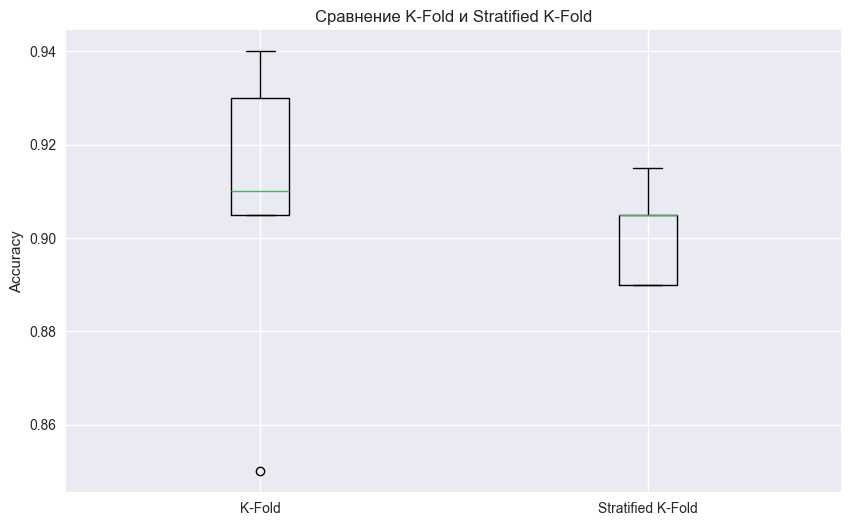


Анализ стабильности результатов:
K-Fold:
  Средняя accuracy = 0.9070
  Std = 0.0312

Stratified K-Fold:
  Средняя accuracy = 0.9010
  Std = 0.0097

Распределение классов валидационных фолдов (K-Fold):
Fold 1: класс 0 = 78.50%, класс 1 = 21.50%
Fold 2: класс 0 = 81.50%, класс 1 = 18.50%
Fold 3: класс 0 = 81.00%, класс 1 = 19.00%
Fold 4: класс 0 = 79.50%, класс 1 = 20.50%
Fold 5: класс 0 = 78.50%, класс 1 = 21.50%


In [5]:
from sklearn.base import clone

# Создание несбалансированного датасета
X_imb, y_imb = make_classification(n_samples=1000, n_features=20, n_classes=2, 
                                  weights=[0.8, 0.2], random_state=42)

print(f"Распределение классов в несбалансированных данных: {np.bincount(y_imb)}")
print(f"Пропорции: класс 0 = {np.mean(y_imb == 0):.2%}, класс 1 = {np.mean(y_imb == 1):.2%}")

def compare_cv_methods(X, y, model, k=5):
    """
    TODO: Реализуйте сравнение K-Fold и Stratified K-Fold кросс-валидации
    
    Требования:
    1. Используйте K-Fold с shuffle=True
    2. Используйте StratifiedKFold с shuffle=True
    3. Вычислите accuracy для каждого фолда
    4. Создайте визуализацию результатов
    5. Проанализируйте распределение классов в каждом фолде для K-Fold
    
    Параметры:
    X : array-like - признаки
    y : array-like - целевая переменная
    model : sklearn estimator - модель для обучения
    k : int - количество фолдов
    
    Возвращает:
    dict с результатами обеих методов
    """
    results = {}
    
    # Ваш код здесь
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    kf_scores = []
    kf_class_distributions = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = clone(model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        kf_scores.append(acc)

        # сохраняем распределение классов в фолде
        kf_class_distributions.append(np.bincount(y_val))

    # =========================
    # 2. Stratified K-Fold
    # =========================
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    skf_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = clone(model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        skf_scores.append(acc)

    # =========================
    # 3. Визуализация
    # =========================
    plt.figure()
    plt.boxplot([kf_scores, skf_scores], labels=["K-Fold", "Stratified K-Fold"])
    plt.ylabel("Accuracy")
    plt.title("Сравнение K-Fold и Stratified K-Fold")
    plt.show()

    # =========================
    # 4. Сохранение результатов
    # =========================
    results["kfold"] = {
        "scores": kf_scores,
        "mean": np.mean(kf_scores),
        "std": np.std(kf_scores),
        "class_distribution": kf_class_distributions
    }

    results["stratified_kfold"] = {
        "scores": skf_scores,
        "mean": np.mean(skf_scores),
        "std": np.std(skf_scores)
    }

    return results

# Тестирование
model = LogisticRegression(random_state=42, max_iter=1000)
cv_results = compare_cv_methods(X_imb, y_imb, model)

# Дополнительный анализ: проверка стабильности результатов
print("\nАнализ стабильности результатов:")

print(f"K-Fold:")
print(f"  Средняя accuracy = {cv_results['kfold']['mean']:.4f}")
print(f"  Std = {cv_results['kfold']['std']:.4f}")

print(f"\nStratified K-Fold:")
print(f"  Средняя accuracy = {cv_results['stratified_kfold']['mean']:.4f}")
print(f"  Std = {cv_results['stratified_kfold']['std']:.4f}")
print("\nРаспределение классов валидационных фолдов (K-Fold):")
for i, dist in enumerate(cv_results["kfold"]["class_distribution"], 1):
    total = dist.sum()
    print(f"Fold {i}: класс 0 = {dist[0]/total:.2%}, класс 1 = {dist[1]/total:.2%}")

# TODO: Добавьте вычисление стандартного отклонения для каждого метода
# и сделайте вывод о том, какой метод более стабилен для данных с дисбалансом классов

## TODO 3: Вычисление и интерпретация метрик классификации

**Задание:** Создайте функцию для комплексного анализа результатов классификации с множественными метриками.

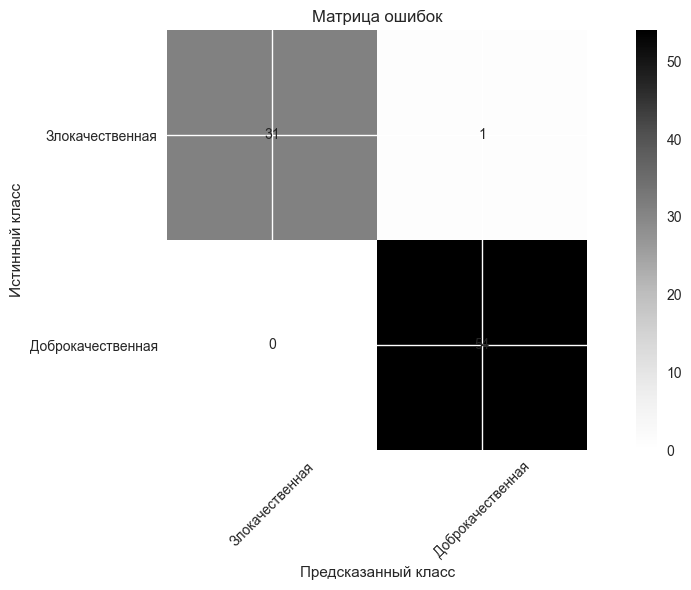

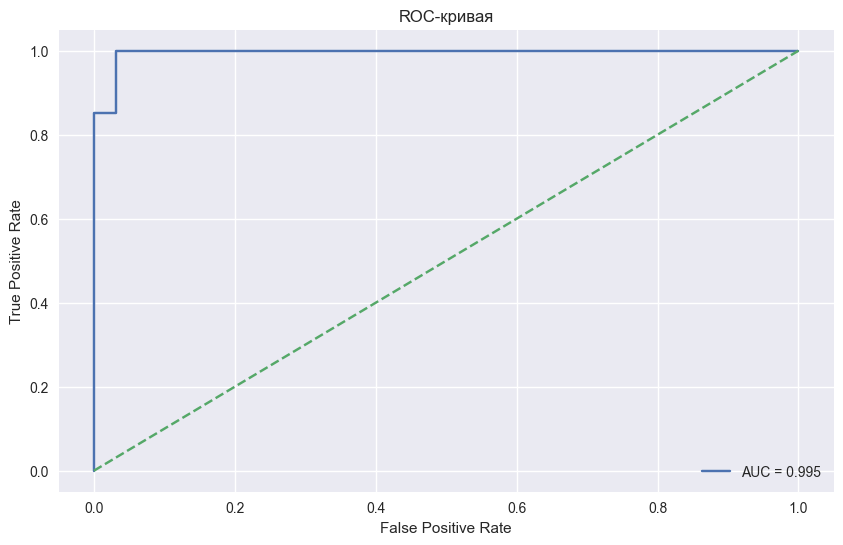

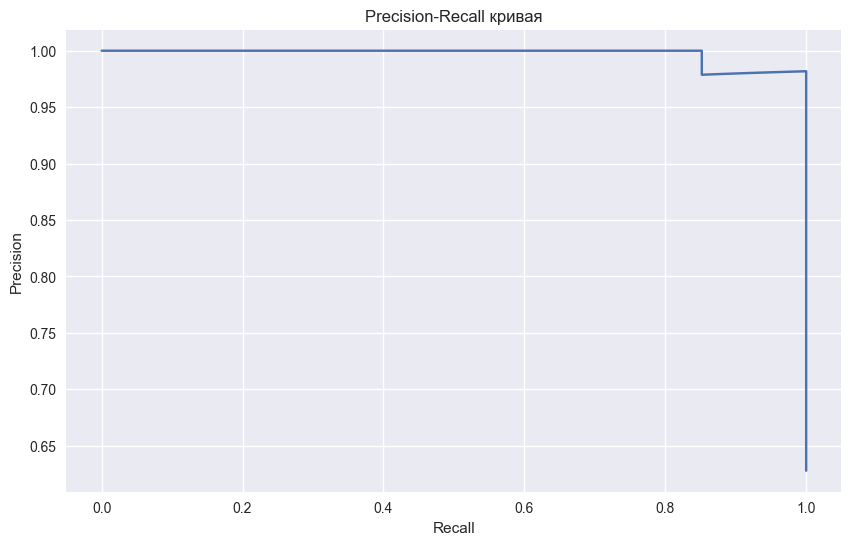


Сводная таблица метрик:


,Метрика,Значение
0,Accuracy,0.988372
1,Precision,0.981818
2,Recall,1.000000
3,F1-score,0.990826



Подробный classification report:
                   precision    recall  f1-score   support

  Злокачественная       1.00      0.97      0.98        32
Доброкачественная       0.98      1.00      0.99        54

         accuracy                           0.99        86
        macro avg       0.99      0.98      0.99        86
     weighted avg       0.99      0.99      0.99        86


Интерпретация результатов:


In [6]:
def comprehensive_classification_report(y_true, y_pred, y_pred_proba=None, class_names=None):
    """
    TODO: Создайте функцию для комплексного анализа результатов классификации
    
    Требования:
    1. Вычислите основные метрики: accuracy, precision, recall, f1-score
    2. Постройте матрицу ошибок с аннотациями
    3. Если есть вероятности, вычислите AUC-ROC и постройте ROC-кривую
    4. Постройте Precision-Recall кривую
    5. Создайте сводную таблицу метрик
    6. Добавьте интерпретацию результатов
    
    Параметры:
    y_true : array-like - истинные метки
    y_pred : array-like - предсказанные метки
    y_pred_proba : array-like, optional - вероятности класса 1
    class_names : list, optional - названия классов
    
    Возвращает:
    dict с вычисленными метриками
    """
    metrics = {}
    
    # Ваш код здесь
    if class_names is None:
        class_names = ["Class 0", "Class 1"]

    # =========================
    # 1. Основные метрики
    # =========================
    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred)
    metrics["recall"] = recall_score(y_true, y_pred)
    metrics["f1_score"] = f1_score(y_true, y_pred)

    # =========================
    # 2. Матрица ошибок
    # =========================
    cm = confusion_matrix(y_true, y_pred)
    metrics["confusion_matrix"] = cm

    plt.figure()
    plt.imshow(cm)
    plt.title("Матрица ошибок")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center")

    plt.ylabel("Истинный класс")
    plt.xlabel("Предсказанный класс")
    plt.tight_layout()
    plt.show()

    # =========================
    # 3. ROC-AUC и ROC-кривая
    # =========================
    if y_pred_proba is not None:
        auc = roc_auc_score(y_true, y_pred_proba)
        metrics["roc_auc"] = auc

        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC-кривая")
        plt.legend()
        plt.show()

        # =========================
        # 4. Precision-Recall кривая
        # =========================
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)

        plt.figure()
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall кривая")
        plt.show()

    # =========================
    # 5. Сводная таблица метрик
    # =========================
    summary_table = pd.DataFrame({
        "Метрика": ["Accuracy", "Precision", "Recall", "F1-score"],
        "Значение": [
            metrics["accuracy"],
            metrics["precision"],
            metrics["recall"],
            metrics["f1_score"]
        ]
    })

    metrics["summary_table"] = summary_table

    print("\nСводная таблица метрик:")
    display(summary_table)

    # =========================
    # 6. Текстовый отчёт sklearn
    # =========================
    print("\nПодробный classification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    return metrics

# Тестирование на реальных данных
# Обучение модели
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Применение функции
class_names = ['Злокачественная', 'Доброкачественная']
report = comprehensive_classification_report(y_test, y_pred, y_pred_proba, class_names)

# TODO: Добавьте интерпретацию результатов
print("\nИнтерпретация результатов:")
# Напишите анализ полученных метрик и их значение для медицинской диагностики

## TODO 4: Анализ кривых обучения

**Задание:** Создайте функцию для построения и анализа кривых обучения для диагностики переобучения и недообучения.

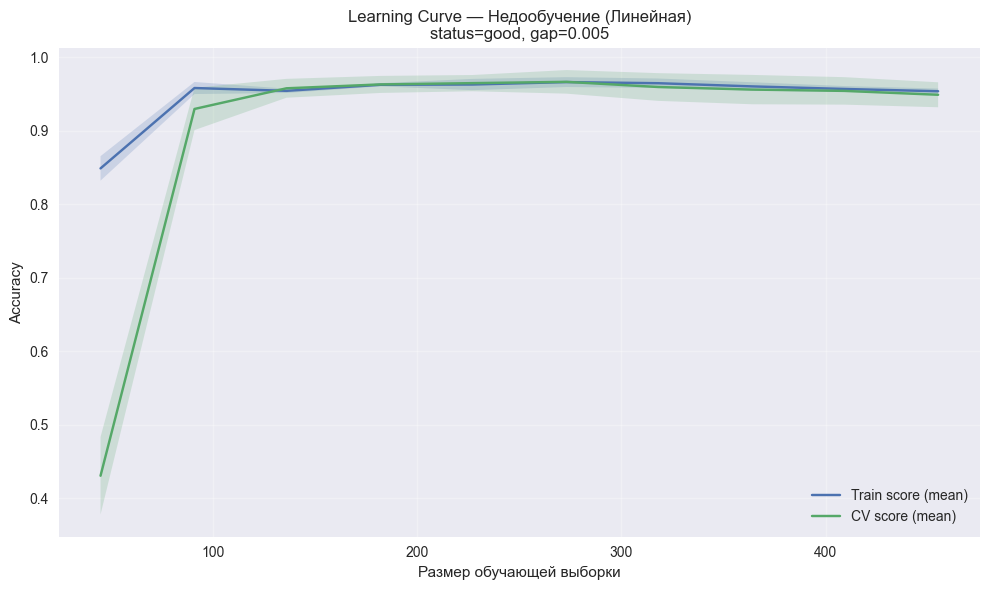

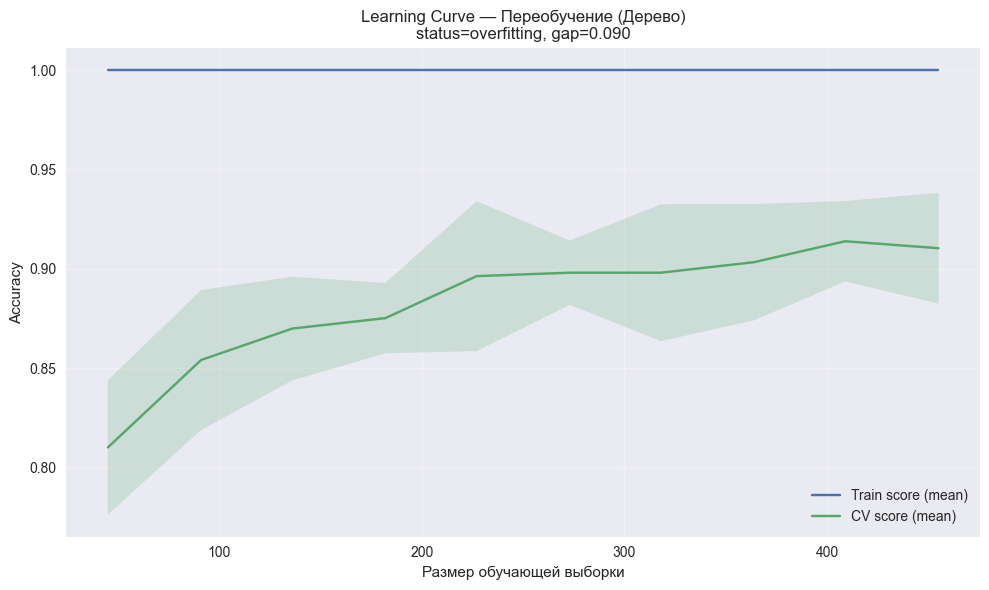

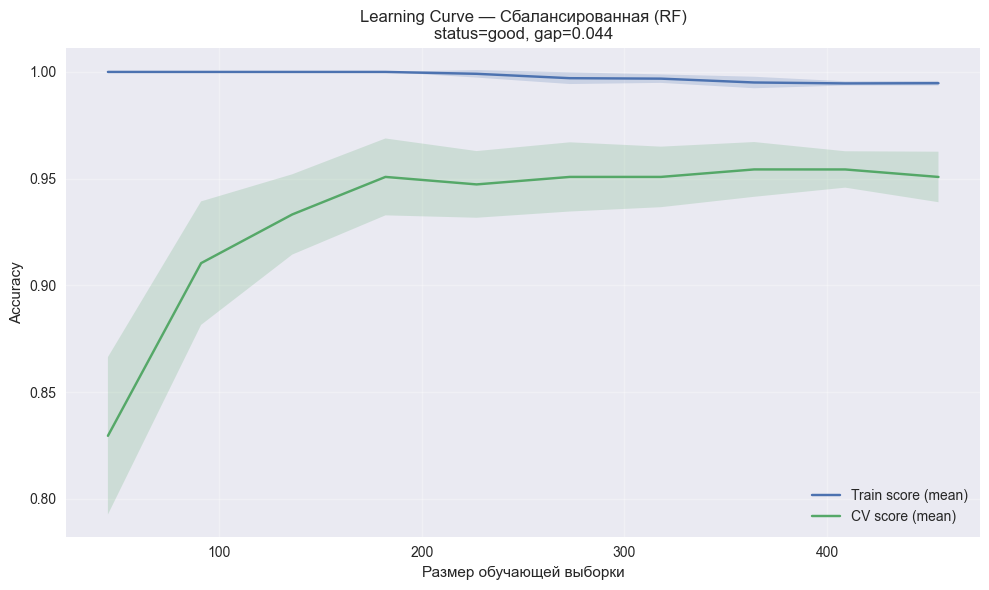

In [8]:
def analyze_learning_curves(models_dict, X, y, cv=5, train_sizes=None):
    """
    TODO: Создайте функцию для анализа кривых обучения нескольких моделей
    
    Требования:
    1. Постройте кривые обучения для каждой модели
    2. Используйте различные размеры обучающей выборки
    3. Покажите доверительные интервалы (среднее ± стандартное отклонение)
    4. Проанализируйте наличие переобучения/недообучения
    5. Создайте рекомендации по улучшению каждой модели
    
    Параметры:
    models_dict : dict - словарь с моделями {название: модель}
    X : array-like - признаки
    y : array-like - целевая переменная
    cv : int - количество фолдов для кросс-валидации
    train_sizes : array-like - размеры обучающих выборок
    
    Возвращает:
    dict с анализом каждой модели
    """
    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 10)
    
    analysis_results = {}
    
    # Ваш код здесь
    if isinstance(cv, int):
        cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    else:
        cv_splitter = cv

    analysis_results = {}

    for name, model in models_dict.items():
        train_sizes_abs, train_scores, val_scores = learning_curve(
            estimator=model,
            X=X,
            y=y,
            cv=cv_splitter,
            train_sizes=train_sizes,
            scoring="accuracy",
            n_jobs=-1
        )

        train_mean = train_scores.mean(axis=1)
        train_std  = train_scores.std(axis=1)

        val_mean = val_scores.mean(axis=1)
        val_std  = val_scores.std(axis=1)

        # Берём поведение на "почти полном" датасете (последняя точка)
        last_train = float(train_mean[-1])
        last_val   = float(val_mean[-1])
        gap        = float(last_train - last_val)

        # Простая диагностика
        # (пороги можно менять, но так обычно ок для учебных работ)
        if last_train < 0.90 and last_val < 0.90 and gap < 0.05:
            status = "underfitting"  # обе низкие, разрыв небольшой
        elif gap >= 0.07 and last_train >= 0.95 and last_val < last_train:
            status = "overfitting"   # высокий train, заметный разрыв
        else:
            status = "good"          # более-менее сбалансировано

        # ====== Визуализация (по одной фигуре на модель) ======
        plt.figure()
        plt.plot(train_sizes_abs, train_mean, label="Train score (mean)")
        plt.plot(train_sizes_abs, val_mean, label="CV score (mean)")

        # доверительные интервалы mean ± std
        plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2)
        plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2)

        plt.title(f"Learning Curve — {name}\nstatus={status}, gap={gap:.3f}")
        plt.xlabel("Размер обучающей выборки")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        analysis_results[name] = {
            "train_sizes": train_sizes_abs,
            "train_mean": train_mean,
            "train_std": train_std,
            "val_mean": val_mean,
            "val_std": val_std,
            "last_train": last_train,
            "last_val": last_val,
            "gap": gap,
            "status": status
        }

    return analysis_results

# Определение моделей для анализа
models_to_analyze = {
    'Недообучение (Линейная)': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=0.01, random_state=42, max_iter=1000))
    ]),
    'Переобучение (Дерево)': DecisionTreeClassifier(max_depth=None, random_state=42),
    'Сбалансированная (RF)': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Анализ кривых обучения
learning_analysis = analyze_learning_curves(models_to_analyze, X, y)

# TODO: Добавьте функцию для генерации рекомендаций
def generate_recommendations(analysis_results):
    """
    TODO: На основе анализа кривых обучения дайте рекомендации:
    1. Если модель недообучается - что делать?
    2. Если модель переобучается - как это исправить?
    3. Какая модель лучше подходит для данной задачи?
    """
    recommendations = {}
    
    # Ваш код здесь
    # Определим "лучшую" модель по последнему CV-скор (val_mean[-1])
    best_name = None
    best_val = -1.0

    for name, info in analysis_results.items():
        last_val = info["last_val"]
        if last_val > best_val:
            best_val = last_val
            best_name = name

    for name, info in analysis_results.items():
        status = info["status"]
        gap = info["gap"]
        last_train = info["last_train"]
        last_val = info["last_val"]

        recs = []
        diagnosis = ""

        if status == "underfitting":
            diagnosis = "Недообучение: и train, и CV accuracy низкие, разрыв небольшой."
            recs += [
                "Увеличить сложность модели (например, ослабить регуляризацию для линейных моделей: увеличить C).",
                "Добавить/улучшить признаки (feature engineering), проверить масштабирование/нормализацию.",
                "Попробовать более выразительные модели (RF/GB, SVM с RBF, Gradient Boosting).",
                "Проверить качество данных: шум, выбросы, информативность признаков."
            ]

        elif status == "overfitting":
            diagnosis = "Переобучение: train accuracy заметно выше CV accuracy (разрыв большой)."
            recs += [
                "Упростить модель (например, ограничить max_depth, min_samples_leaf/min_samples_split у дерева).",
                "Добавить регуляризацию (для линейных — уменьшить C; для деревьев — pruning/ограничения).",
                "Увеличить данные (больше примеров) или использовать data augmentation (если применимо).",
                "Использовать ансамблирование/бэггинг (RandomForest) или настройку гиперпараметров через CV."
            ]

        else:
            diagnosis = "Сбалансировано: хорошее качество, разрыв небольшой/умеренный."
            recs += [
                "Тонкая настройка гиперпараметров (GridSearch/RandomizedSearch).",
                "Проверить дополнительные метрики (ROC-AUC, F1) — особенно если важнее не accuracy.",
                "Оценить важность признаков (для RF) и убрать шумные/дублирующие признаки."
            ]

        recommendations[name] = {
            "status": status,
            "diagnosis": diagnosis,
            "summary": {
                "last_train_accuracy": round(last_train, 4),
                "last_cv_accuracy": round(last_val, 4),
                "gap": round(gap, 4)
            },
            "recommendations": recs,
            "is_best": (name == best_name)
        }

    recommendations["_best_model"] = {
        "name": best_name,
        "reason": f"Наивысшая последняя CV accuracy: {best_val:.4f}"
    }

    return recommendations

recommendations = generate_recommendations(learning_analysis)

## TODO 5: Настройка гиперпараметров с валидацией

**Задание:** Реализуйте систему для настройки гиперпараметров с proper validation и анализом результатов.

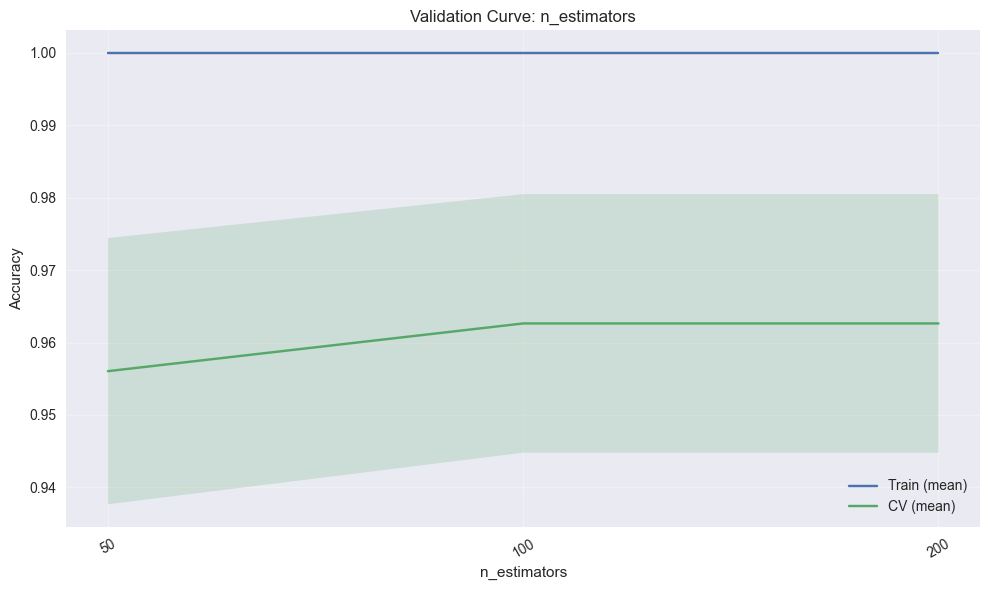

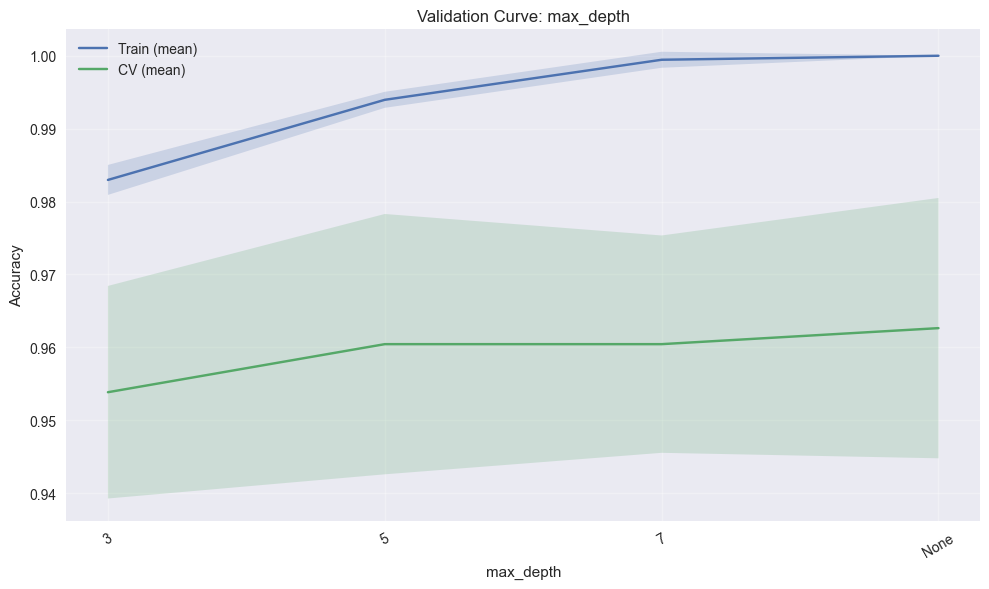

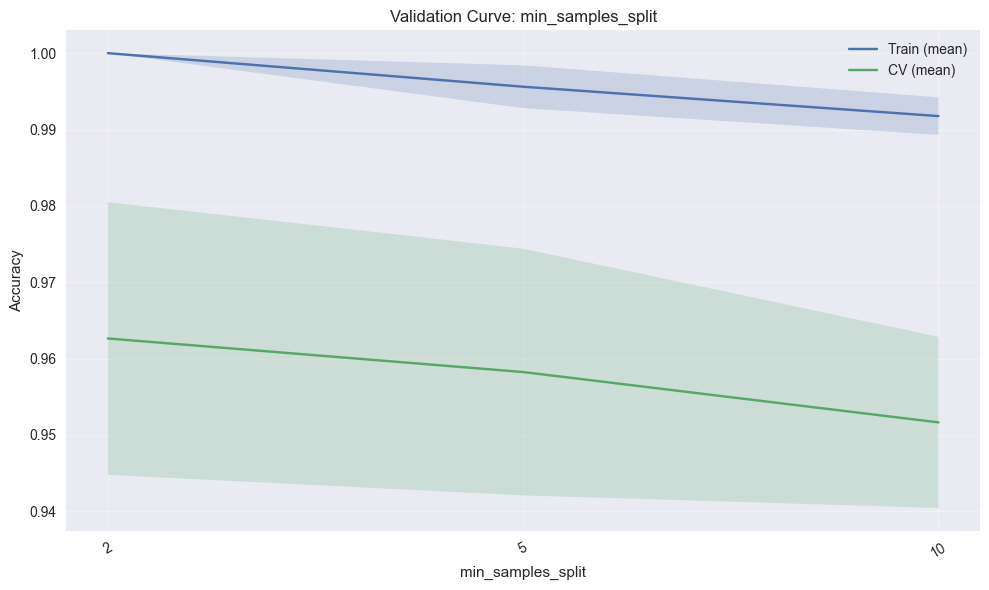

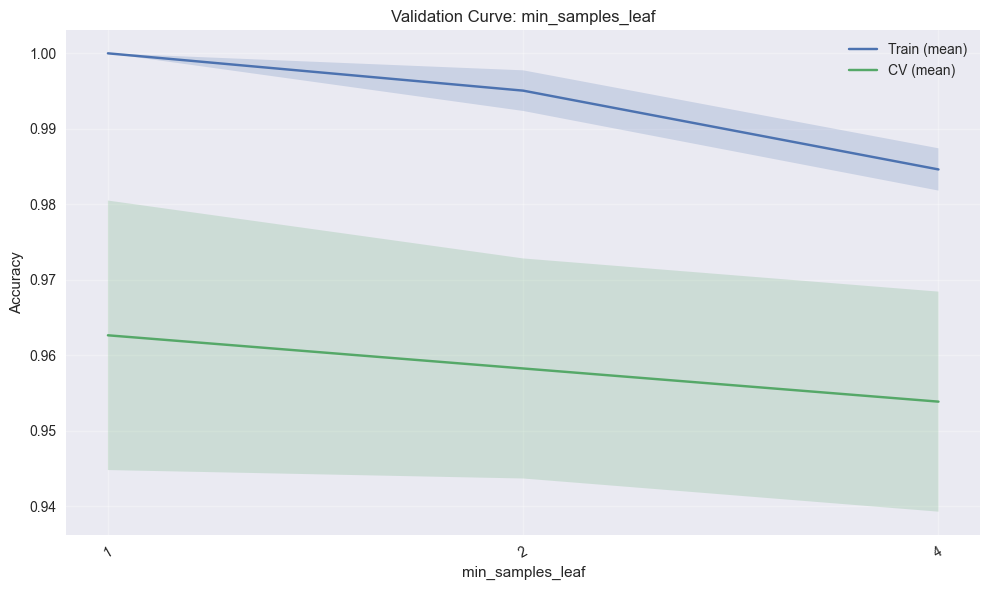

In [10]:
def hyperparameter_tuning_with_validation(X, y, model_class, param_grid, cv=5, test_size=0.2):
    """
    TODO: Реализуйте правильную настройку гиперпараметров
    
    Требования:
    1. Разделите данные на train/test ПЕРЕД настройкой
    2. Используйте GridSearchCV на обучающих данных
    3. Найдите лучшие параметры с помощью кросс-валидации
    4. Оцените лучшую модель на тестовых данных
    5. Постройте validation curves для ключевых параметров
    6. Проанализируйте, не переобучается ли процесс выбора гиперпараметров
    
    Параметры:
    X : array-like - признаки
    y : array-like - целевая переменная
    model_class : class - класс модели
    param_grid : dict - сетка параметров
    cv : int - количество фолдов
    test_size : float - размер тестовой выборки
    
    Возвращает:
    dict с результатами настройки
    """
    results = {}
    
    # Ваш код здесь
    # 1) Train/Test split ДО настройки (важно!)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    # 2) CV splitter (стратификация)
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # 3) GridSearchCV на train
    base_model = model_class(random_state=42) if "random_state" in model_class().get_params() else model_class()
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv_splitter,
        n_jobs=-1,
        return_train_score=True
    )
    grid.fit(X_train, y_train)

    # 4) Лучшая модель + оценка на test
    best_model = grid.best_estimator_
    y_test_pred = best_model.predict(X_test)

    test_acc = accuracy_score(y_test, y_test_pred)
    best_cv_acc = grid.best_score_

    results["best_params"] = grid.best_params_
    results["best_cv_score"] = best_cv_acc
    results["test_score"] = test_acc
    results["generalization_gap"] = best_cv_acc - test_acc  # если большой +, возможно переобучение на CV/подбор
    results["best_estimator"] = best_model
    results["grid_search"] = grid
    results["train_test_split"] = {
        "X_train_shape": X_train.shape,
        "X_test_shape": X_test.shape
    }

    # 5) Validation curves для “ключевых” параметров
    # Выбираем несколько наиболее важных параметров, если они есть в сетке
    key_params_order = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]
    key_params = [p for p in key_params_order if p in param_grid]

    val_curves = {}

    for param_name in key_params:
        param_range = param_grid[param_name]

        # validation_curve требует estimator; используем базовую модель (не tuned),
        # чтобы видеть, как параметр влияет в целом
        estimator_for_curve = clone(base_model)

        train_scores, val_scores = validation_curve(
            estimator=estimator_for_curve,
            X=X_train,
            y=y_train,
            param_name=param_name,
            param_range=param_range,
            cv=cv_splitter,
            scoring="accuracy",
            n_jobs=-1
        )

        train_mean = train_scores.mean(axis=1)
        train_std  = train_scores.std(axis=1)
        val_mean   = val_scores.mean(axis=1)
        val_std    = val_scores.std(axis=1)

        val_curves[param_name] = {
            "param_range": param_range,
            "train_mean": train_mean,
            "train_std": train_std,
            "val_mean": val_mean,
            "val_std": val_std
        }

        # --- plot
        plt.figure()
        x = np.arange(len(param_range))
        plt.plot(x, train_mean, label="Train (mean)")
        plt.plot(x, val_mean, label="CV (mean)")
        plt.fill_between(x, train_mean - train_std, train_mean + train_std, alpha=0.2)
        plt.fill_between(x, val_mean - val_std, val_mean + val_std, alpha=0.2)

        # подписи значений параметра на x
        plt.xticks(x, [str(v) for v in param_range], rotation=30)
        plt.xlabel(param_name)
        plt.ylabel("Accuracy")
        plt.title(f"Validation Curve: {param_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    results["validation_curves"] = val_curves

    # 6) Анализ: не переобучается ли процесс выбора гиперпараметров?
    # Простой критерий: если CV score заметно выше test score — риск “подгонки” под CV
    gap = results["generalization_gap"]
    if gap > 0.03:
        results["tuning_overfit_warning"] = (
            f"Возможная подгонка под CV: best CV={best_cv_acc:.4f} заметно выше test={test_acc:.4f} "
            f"(gap={gap:.4f}). Рассмотри Nested CV или уменьшение поисковой сетки/регуляризацию."
        )
    else:
        results["tuning_overfit_warning"] = (
            f"Сильной подгонки под CV не видно: best CV={best_cv_acc:.4f}, test={test_acc:.4f}, gap={gap:.4f}."
        )

    # Полезная таблица результатов grid search
    cv_df = pd.DataFrame(grid.cv_results_)
    # Оставим основные столбцы для удобства
    keep_cols = [c for c in cv_df.columns if c.startswith("param_")] + [
        "mean_train_score", "std_train_score", "mean_test_score", "std_test_score", "rank_test_score"
    ]
    results["cv_results_df"] = cv_df[keep_cols].sort_values("rank_test_score")
    return results

# Настройка гиперпараметров для Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tuning_results = hyperparameter_tuning_with_validation(
    X, y, RandomForestClassifier, rf_param_grid
)

# TODO: Добавьте функцию для анализа важности параметров
def analyze_parameter_importance(grid_search_results):
    """
    TODO: Проанализируйте, какие параметры наиболее важны для производительности
    1. Постройте heatmap корреляций между параметрами и производительностью
    2. Определите параметры с наибольшим влиянием
    3. Найдите взаимодействия между параметрами
    """
    df = pd.DataFrame(grid_search_results.cv_results_).copy()

    score_col = "mean_test_score"

    # 1) Соберем таблицу параметров
    param_cols = [c for c in df.columns if c.startswith("param_")]
    params_df = df[param_cols].copy()

    # 2) Приведём параметры к числам где возможно
    # None -> np.nan; категориальные -> коды
    for col in params_df.columns:
        # заменим None на nan
        params_df[col] = params_df[col].apply(lambda x: np.nan if x is None else x)

        # если не числовой тип, закодируем
        if not np.issubdtype(params_df[col].dtype, np.number):
            params_df[col] = params_df[col].astype("category").cat.codes

    # 3) Корреляции параметров с качеством
    corr_with_score = {}
    for col in params_df.columns:
        # если всё nan — пропускаем
        if params_df[col].isna().all():
            continue
        corr = np.corrcoef(params_df[col].fillna(params_df[col].mean()), df[score_col])[0, 1]
        corr_with_score[col.replace("param_", "")] = corr

    corr_series = pd.Series(corr_with_score).sort_values(key=lambda s: np.abs(s), ascending=False)

    print("Корреляция параметров с mean_test_score (по модулю — важнее):")
    display(corr_series.to_frame("corr").style.format("{:.3f}"))

    # Bar plot корреляций
    plt.figure()
    plt.bar(range(len(corr_series)), corr_series.values)
    plt.xticks(range(len(corr_series)), corr_series.index, rotation=30, ha="right")
    plt.ylabel("Correlation with mean_test_score")
    plt.title("Влияние параметров (корреляции)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4) Взаимодействия: heatmap по двум самым “важным” параметрам (если есть >=2)
    if len(corr_series) >= 2:
        p1, p2 = corr_series.index[0], corr_series.index[1]

        col1 = "param_" + p1
        col2 = "param_" + p2

        pivot = df.pivot_table(
            index=col1,
            columns=col2,
            values=score_col,
            aggfunc="mean"
        )

        plt.figure()
        plt.imshow(pivot.values)
        plt.colorbar(label=score_col)
        plt.title(f"Взаимодействие параметров: {p1} vs {p2}")
        plt.xlabel(p2)
        plt.ylabel(p1)

        plt.xticks(range(len(pivot.columns)), [str(x) for x in pivot.columns], rotation=30)
        plt.yticks(range(len(pivot.index)), [str(x) for x in pivot.index])

        # аннотации чисел
        for i in range(pivot.shape[0]):
            for j in range(pivot.shape[1]):
                val = pivot.values[i, j]
                if not np.isnan(val):
                    plt.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=8)

        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно параметров для анализа взаимодействий (нужно минимум 2).")

    return {
        "corr_series": corr_series,
        "top_params": list(corr_series.index[:3])
    }

# analyze_parameter_importance(tuning_results['grid_search'])

## TODO 6: Валидация для регрессионных задач

**Задание:** Адаптируйте методы валидации для задач регрессии и сравните различные модели.

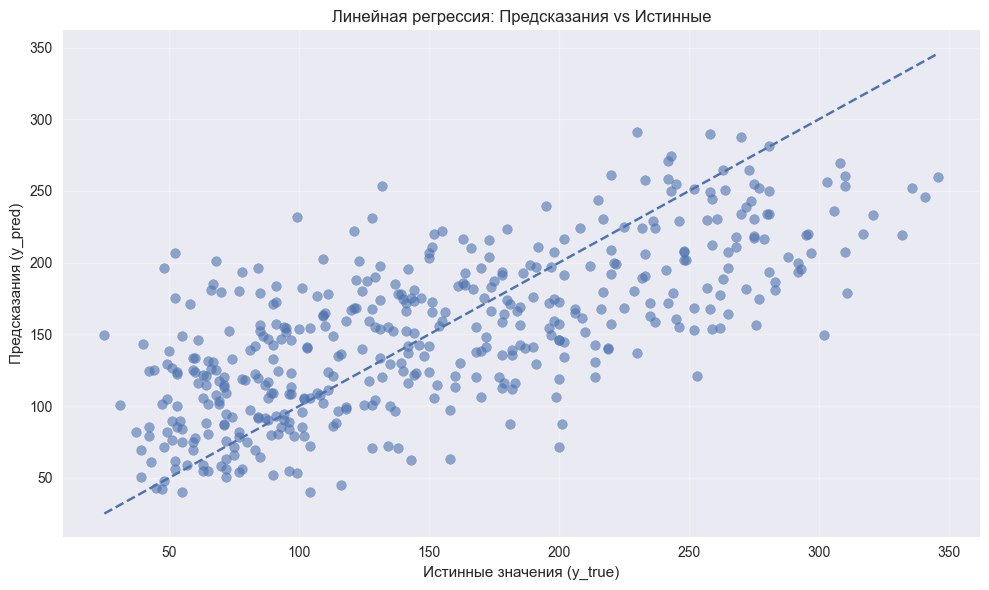

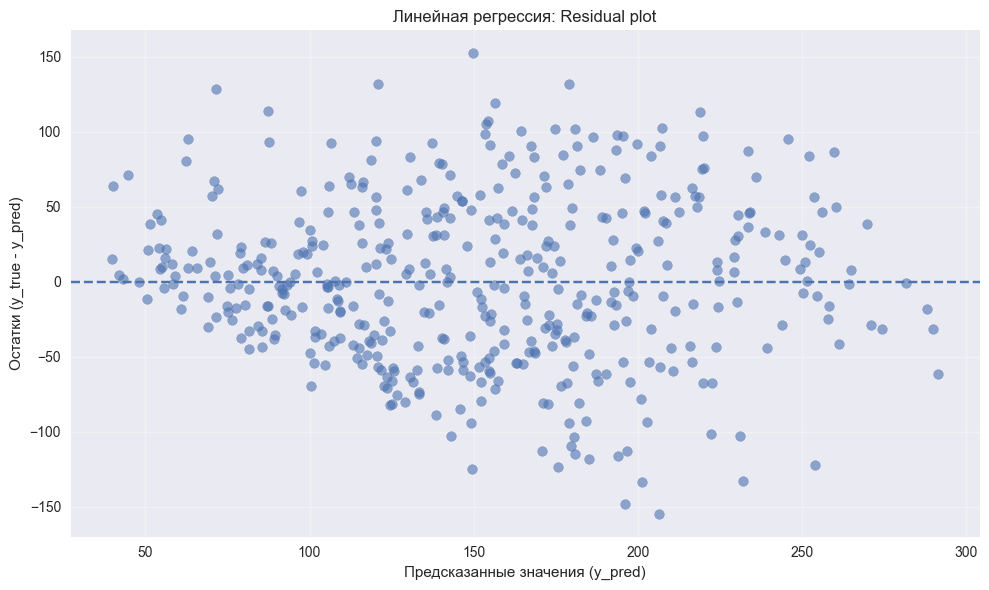

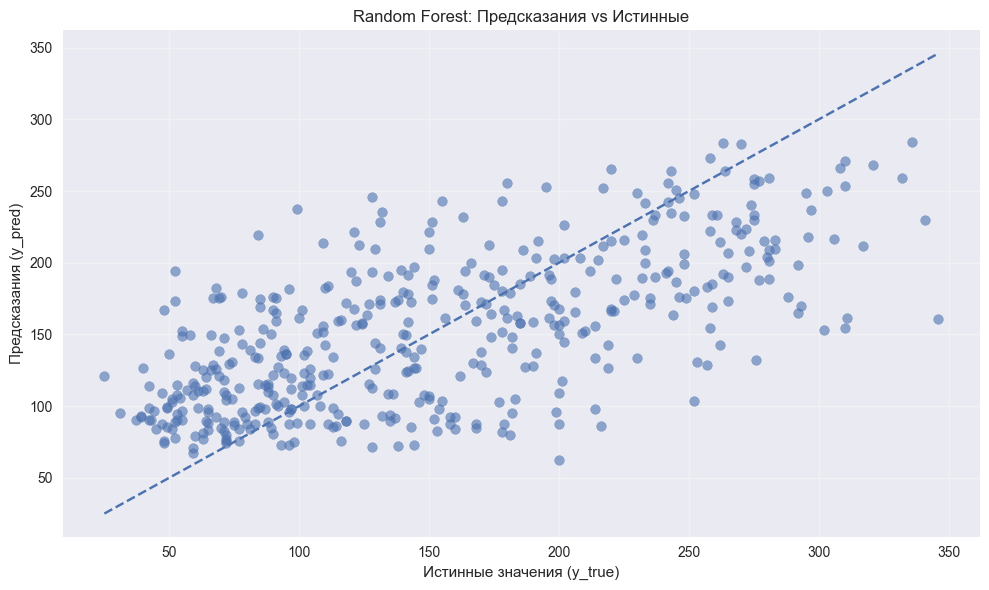

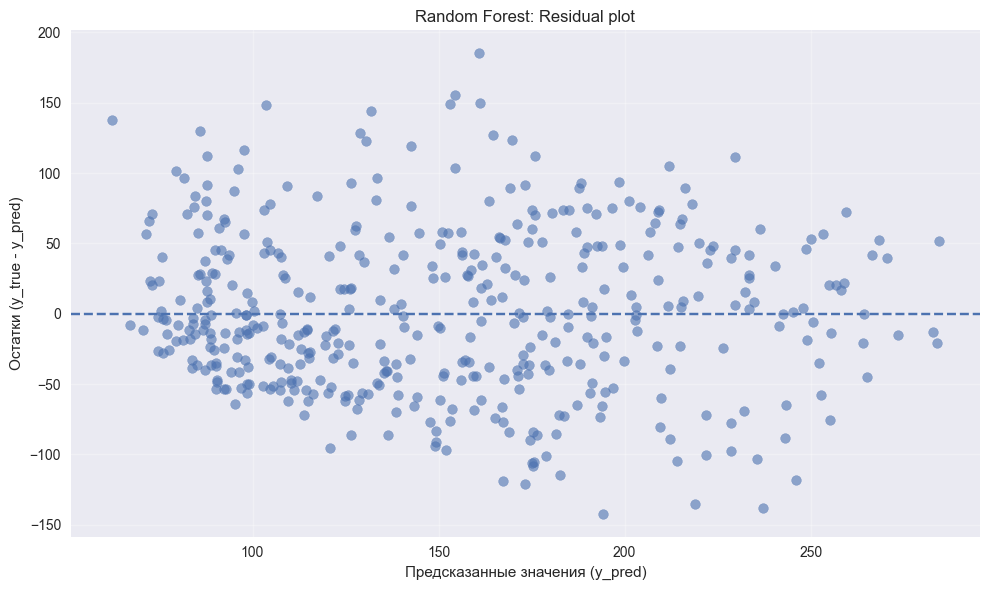

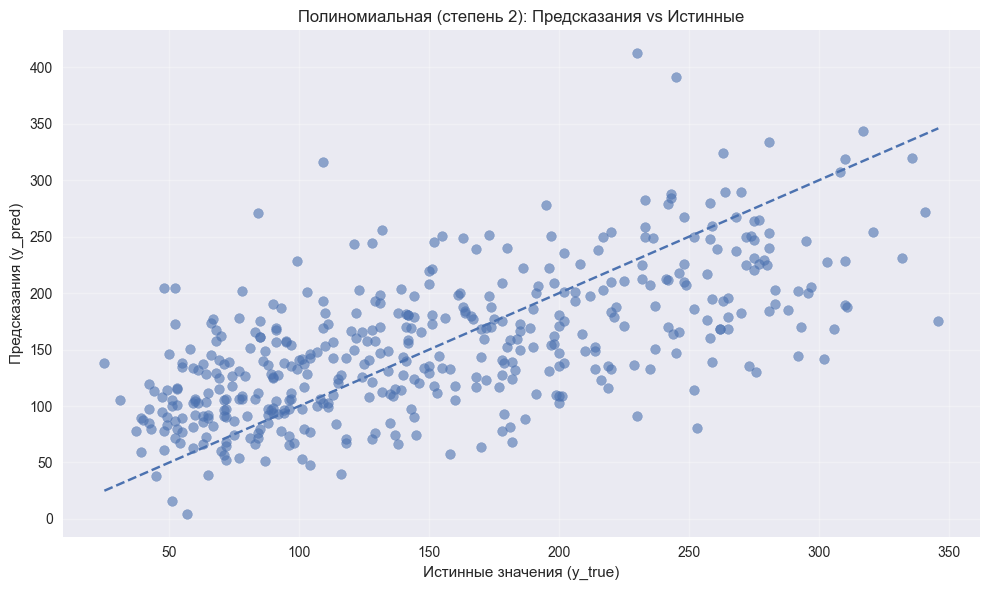

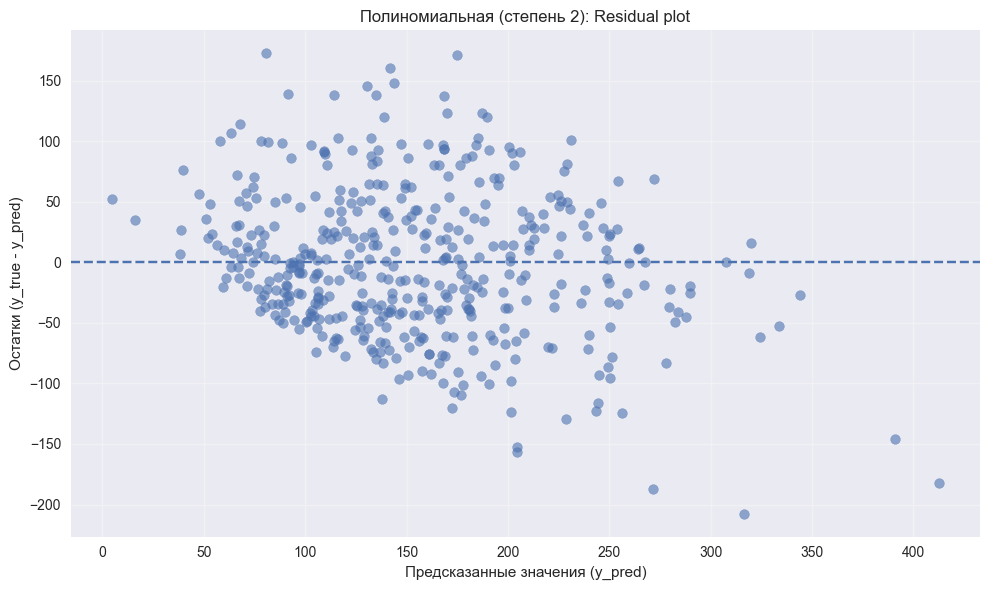


Сводная таблица (CV):


,Модель,MSE (mean±std),MAE (mean±std),R2 (mean±std)
0,Линейная регрессия,3015.38 ± 291.24,44.27 ± 2.61,0.478 ± 0.085
1,Random Forest,3314.63 ± 357.10,46.69 ± 3.01,0.429 ± 0.084
2,Полиномиальная (степень 2),3692.14 ± 547.62,48.32 ± 3.85,0.366 ± 0.106



Статистическое сравнение (парные t-тесты по R2, по фолдам):


,Модель A,Модель B,t-stat,p-value,Средний R2 A,Средний R2 B
2,Random Forest,Полиномиальная (степень 2),3.546801,0.023867,0.429359,0.365770
1,Линейная регрессия,Полиномиальная (степень 2),2.861543,0.045858,0.478470,0.365770
0,Линейная регрессия,Random Forest,1.770587,0.151336,0.478470,0.429359



Лучшая модель по среднему R²: Линейная регрессия


In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import (
    KFold,
    cross_validate,
    cross_val_predict
)
from scipy.stats import ttest_rel

# Загрузка данных для регрессии
diabetes_data = load_diabetes()
X_reg, y_reg = diabetes_data.data, diabetes_data.target

def regression_model_comparison(X, y, models_dict, cv=5):
    """
    TODO: Создайте систему сравнения регрессионных моделей
    
    Требования:
    1. Используйте различные метрики: MSE, MAE, R²
    2. Постройте кросс-валидационные оценки для каждой модели
    3. Создайте residual plots для анализа остатков
    4. Постройте scatter plots предсказаний vs истинных значений
    5. Проведите статистическое сравнение моделей
    6. Проанализируйте, какая модель лучше и почему
    
    Параметры:
    X : array-like - признаки
    y : array-like - целевая переменная
    models_dict : dict - словарь моделей
    cv : int - количество фолдов
    
    Возвращает:
    dict с результатами сравнения
    """
    comparison_results = {}
    
    # Ваш код здесь
    # CV splitter
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Скоринги для cross_validate (в sklearn MSE/MAE обычно "neg_*")
    scoring = {
        "neg_mse": "neg_mean_squared_error",
        "neg_mae": "neg_mean_absolute_error",
        "r2": "r2"
    }

    # 1) CV-оценки и предсказания для графиков
    for name, model in models_dict.items():
        cv_out = cross_validate(
            model, X, y,
            cv=cv_splitter,
            scoring=scoring,
            return_train_score=False
        )

        # Приводим neg_* к положительным значениям ошибок
        mse_scores = -cv_out["test_neg_mse"]
        mae_scores = -cv_out["test_neg_mae"]
        r2_scores  = cv_out["test_r2"]

        # Предсказания через cross_val_predict (для общих графиков без утечки)
        y_pred_cv = cross_val_predict(model, X, y, cv=cv_splitter)

        # Итоговые метрики на CV-predict (не путать с CV mean, но удобно для графиков)
        mse_all = mean_squared_error(y, y_pred_cv)
        mae_all = mean_absolute_error(y, y_pred_cv)
        r2_all  = r2_score(y, y_pred_cv)

        comparison_results[name] = {
            "cv_mse_scores": mse_scores,
            "cv_mae_scores": mae_scores,
            "cv_r2_scores": r2_scores,
            "cv_summary": {
                "mse_mean": float(np.mean(mse_scores)),
                "mse_std":  float(np.std(mse_scores)),
                "mae_mean": float(np.mean(mae_scores)),
                "mae_std":  float(np.std(mae_scores)),
                "r2_mean":  float(np.mean(r2_scores)),
                "r2_std":   float(np.std(r2_scores)),
            },
            "cv_pred_metrics": {
                "mse": float(mse_all),
                "mae": float(mae_all),
                "r2":  float(r2_all)
            },
            "y_pred_cv": y_pred_cv
        }

        # 2) Scatter: y_pred vs y_true
        plt.figure()
        plt.scatter(y, y_pred_cv, alpha=0.6)
        min_y, max_y = float(np.min(y)), float(np.max(y))
        plt.plot([min_y, max_y], [min_y, max_y], linestyle="--")
        plt.xlabel("Истинные значения (y_true)")
        plt.ylabel("Предсказания (y_pred)")
        plt.title(f"{name}: Предсказания vs Истинные")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # 3) Residual plot: residuals vs y_pred
        residuals = y - y_pred_cv
        plt.figure()
        plt.scatter(y_pred_cv, residuals, alpha=0.6)
        plt.axhline(0, linestyle="--")
        plt.xlabel("Предсказанные значения (y_pred)")
        plt.ylabel("Остатки (y_true - y_pred)")
        plt.title(f"{name}: Residual plot")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 4) Сводная таблица
    summary_rows = []
    for name, res in comparison_results.items():
        s = res["cv_summary"]
        summary_rows.append({
            "Модель": name,
            "MSE (mean±std)": f"{s['mse_mean']:.2f} ± {s['mse_std']:.2f}",
            "MAE (mean±std)": f"{s['mae_mean']:.2f} ± {s['mae_std']:.2f}",
            "R2 (mean±std)":  f"{s['r2_mean']:.3f} ± {s['r2_std']:.3f}",
        })

    summary_df = pd.DataFrame(summary_rows).sort_values(
        by="R2 (mean±std)", ascending=False
    )
    comparison_results["summary_table"] = summary_df

    print("\nСводная таблица (CV):")
    display(summary_df)

    # 5) Статистическое сравнение (парные t-тесты по фолдам на R2)
    # Сравним все пары моделей: ttest_rel по r2_scores
    model_names = [n for n in models_dict.keys()]
    stats_rows = []
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            m1, m2 = model_names[i], model_names[j]
            r2_1 = comparison_results[m1]["cv_r2_scores"]
            r2_2 = comparison_results[m2]["cv_r2_scores"]

            t_stat, p_val = ttest_rel(r2_1, r2_2)
            stats_rows.append({
                "Модель A": m1,
                "Модель B": m2,
                "t-stat": float(t_stat),
                "p-value": float(p_val),
                "Средний R2 A": float(np.mean(r2_1)),
                "Средний R2 B": float(np.mean(r2_2)),
            })

    stats_df = pd.DataFrame(stats_rows).sort_values("p-value")
    comparison_results["stat_tests_r2"] = stats_df

    print("\nСтатистическое сравнение (парные t-тесты по R2, по фолдам):")
    display(stats_df)

    # 6) Авто-выбор лучшей модели по среднему R2 (можешь заменить на MAE/MSE)
    best_model = max(model_names, key=lambda n: comparison_results[n]["cv_summary"]["r2_mean"])
    comparison_results["best_model_by_r2"] = best_model

    print(f"\nЛучшая модель по среднему R²: {best_model}")
    return comparison_results

# Определение регрессионных моделей
regression_models = {
    'Линейная регрессия': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Полиномиальная (степень 2)': Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('regressor', LinearRegression())
    ])
}

from sklearn.preprocessing import PolynomialFeatures

# Сравнение моделей
regression_comparison = regression_model_comparison(X_reg, y_reg, regression_models)

# TODO: Добавьте анализ остатков
def analyze_residuals(y_true, y_pred, model_name):
    """
    TODO: Создайте функцию для анализа остатков регрессии
    1. Постройте график остатков vs предсказанных значений
    2. Постройте Q-Q plot для проверки нормальности остатков
    3. Постройте гистограмму остатков
    4. Вычислите статистики остатков
    5. Дайте интерпретацию качества модели
    """
    residuals = y_true - y_pred

    # 1) Остатки vs предсказания
    plt.figure()
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Предсказанные значения (y_pred)")
    plt.ylabel("Остатки (y_true - y_pred)")
    plt.title(f"{model_name}: Остатки vs Предсказания")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2) Q-Q plot (нормальность остатков)
    plt.figure()
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"{model_name}: Q-Q plot остатков")
    plt.tight_layout()
    plt.show()

    # 3) Гистограмма остатков
    plt.figure()
    plt.hist(residuals, bins=30, alpha=0.8)
    plt.xlabel("Остатки")
    plt.ylabel("Частота")
    plt.title(f"{model_name}: Гистограмма остатков")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4) Статистики остатков
    res_mean = float(np.mean(residuals))
    res_std  = float(np.std(residuals))
    res_skew = float(stats.skew(residuals))
    res_kurt = float(stats.kurtosis(residuals))  # excess kurtosis
    shapiro_stat, shapiro_p = stats.shapiro(residuals)  # нормальность (для небольших/средних n)

    stats_dict = {
        "residual_mean": res_mean,
        "residual_std": res_std,
        "skewness": res_skew,
        "kurtosis_excess": res_kurt,
        "shapiro_stat": float(shapiro_stat),
        "shapiro_p": float(shapiro_p),
    }

    print(f"\n{model_name}: Статистики остатков")
    for k, v in stats_dict.items():
        print(f"- {k}: {v:.4f}")

    # 5) Интерпретация (коротко и по делу)
    interpretation = []
    if abs(res_mean) < 1.0:
        interpretation.append("Среднее остатков близко к 0 → выраженного смещения (bias) почти нет.")
    else:
        interpretation.append("Среднее остатков далеко от 0 → возможен систематический сдвиг (bias).")

    if shapiro_p < 0.05:
        interpretation.append("Shapiro-Wilk p < 0.05 → остатки заметно отклоняются от нормальности (часто норма для реальных данных).")
    else:
        interpretation.append("Shapiro-Wilk p ≥ 0.05 → нет сильных оснований отвергать нормальность остатков.")

    interpretation.append("Смотри residual plot: если видна форма (дуга/воронка) → нелинейность или гетероскедастичность.")
    interpretation.append("Если в residual plot есть 'воронка' → дисперсия ошибок растёт, можно пробовать преобразование цели/robust модели.")

    print("\nИнтерпретация:")
    for line in interpretation:
        print("-", line)

    return {"residuals": residuals, "stats": stats_dict, "interpretation": interpretation}

## TODO 7: Валидация временных рядов

**Задание:** Реализуйте специальные методы валидации для данных временных рядов.

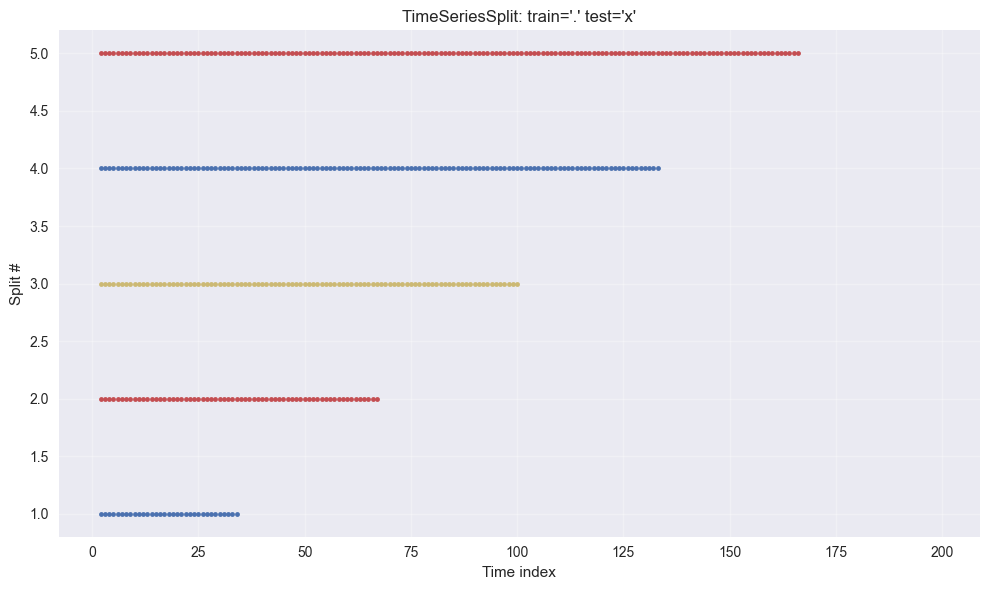

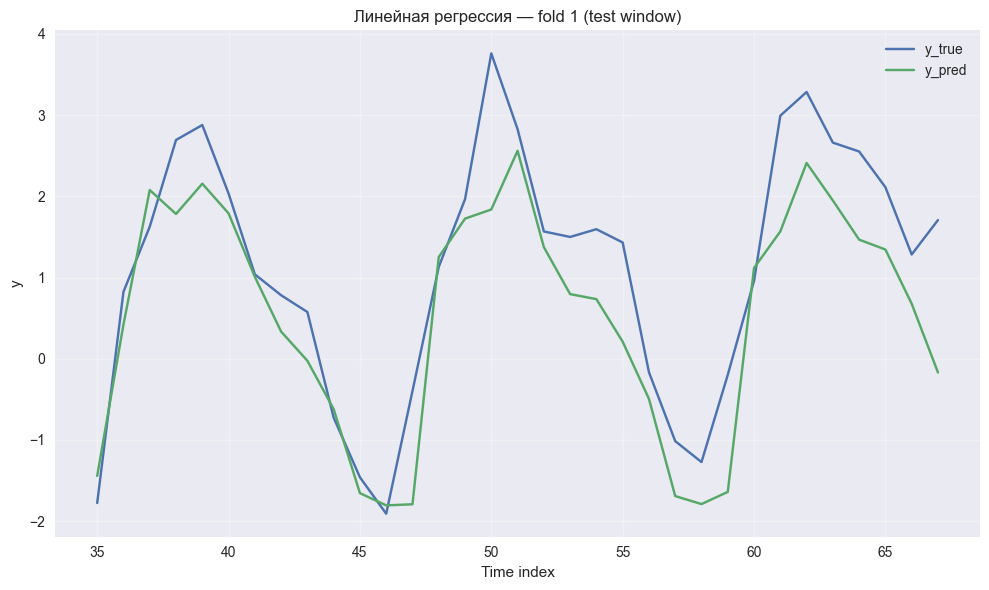

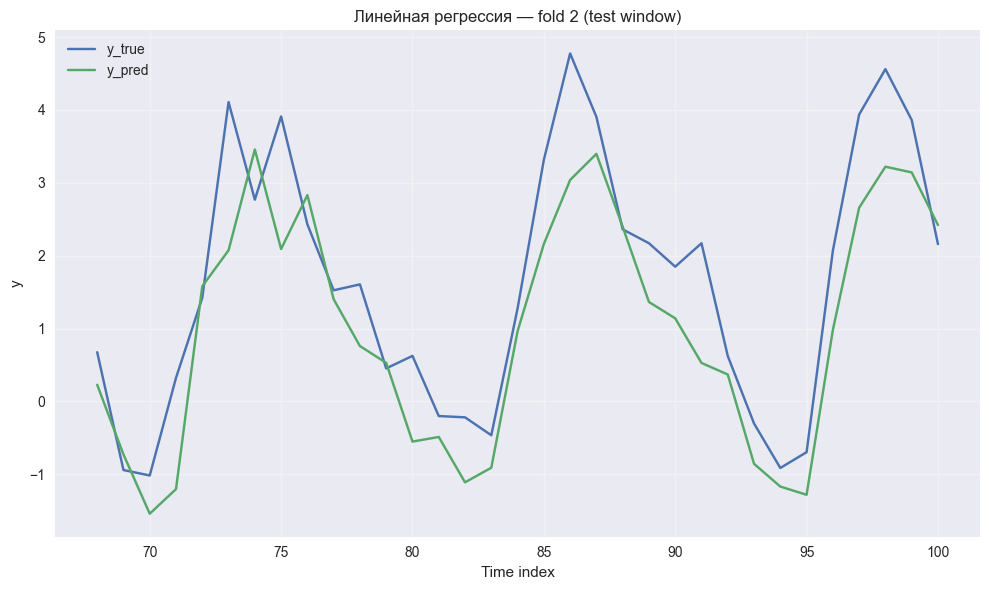

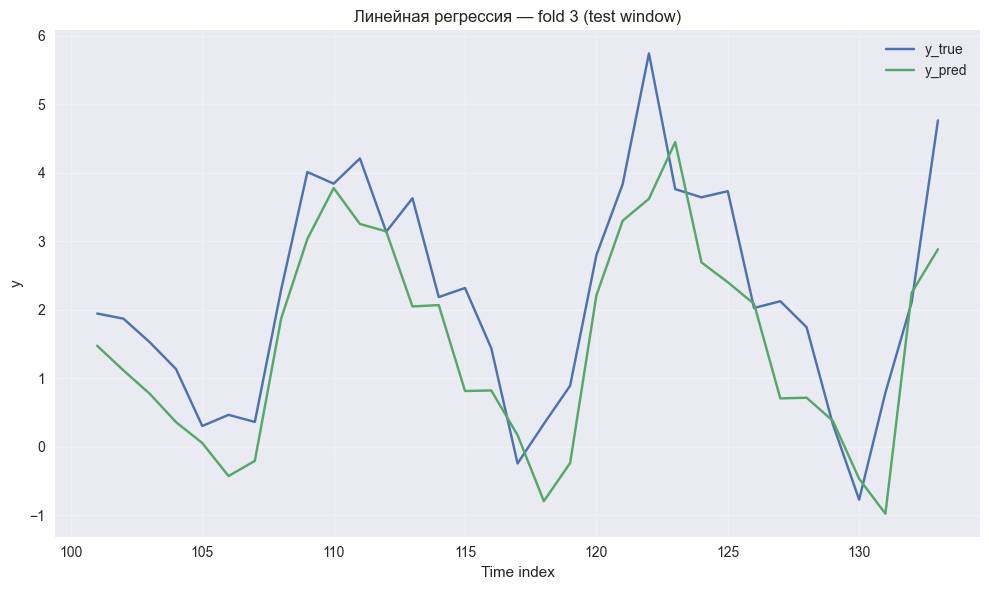

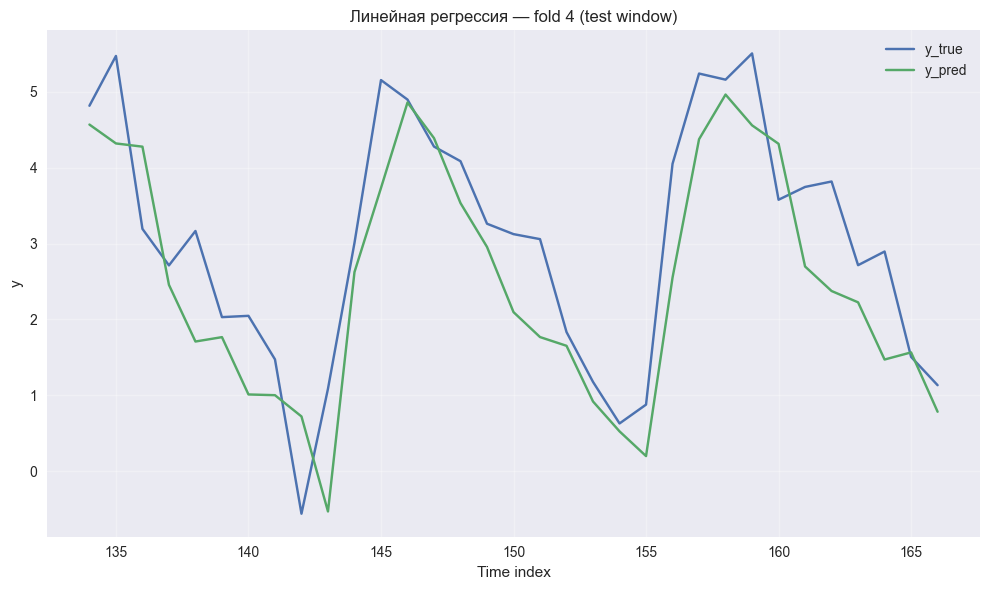

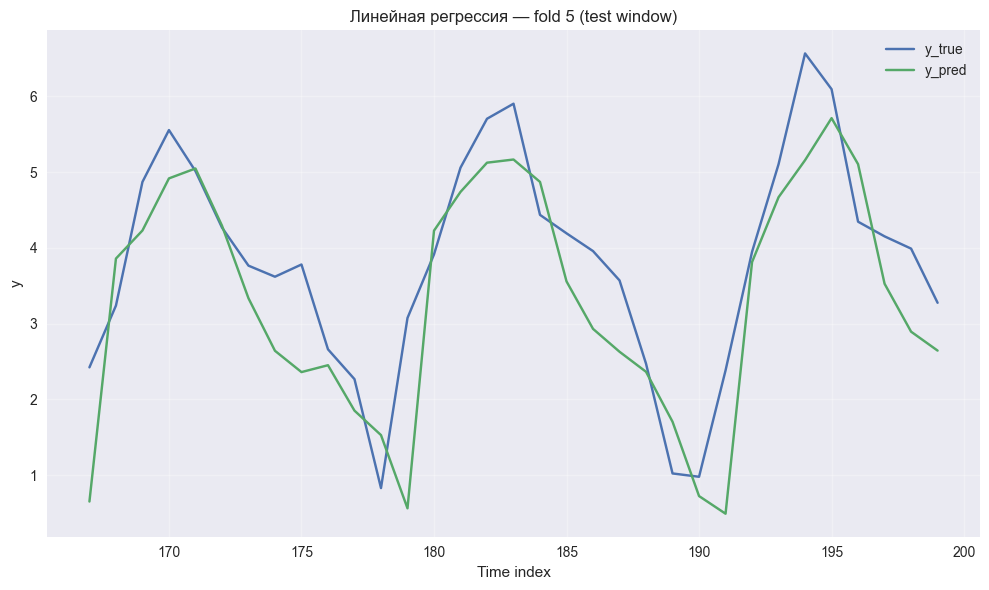

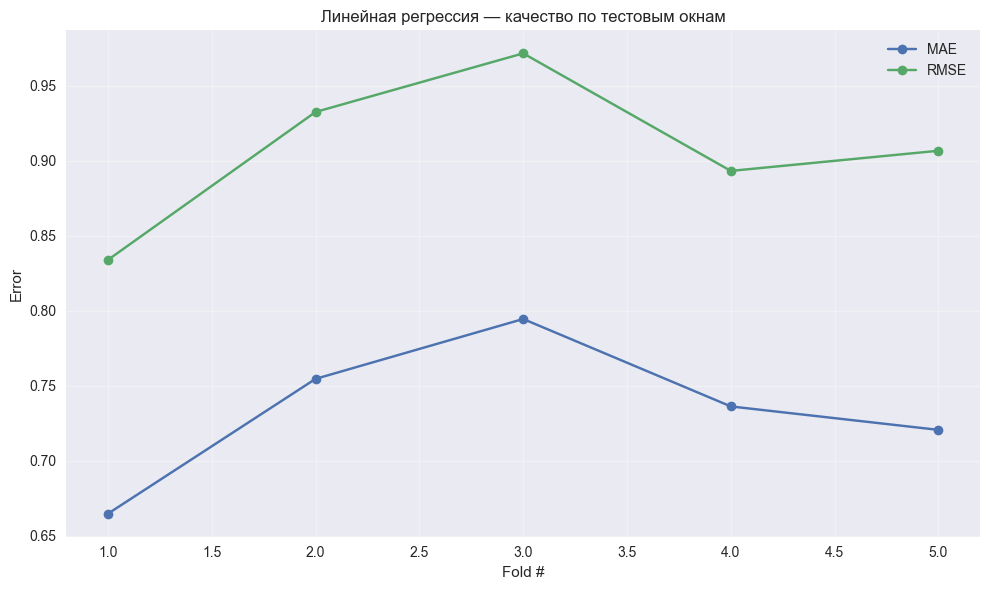

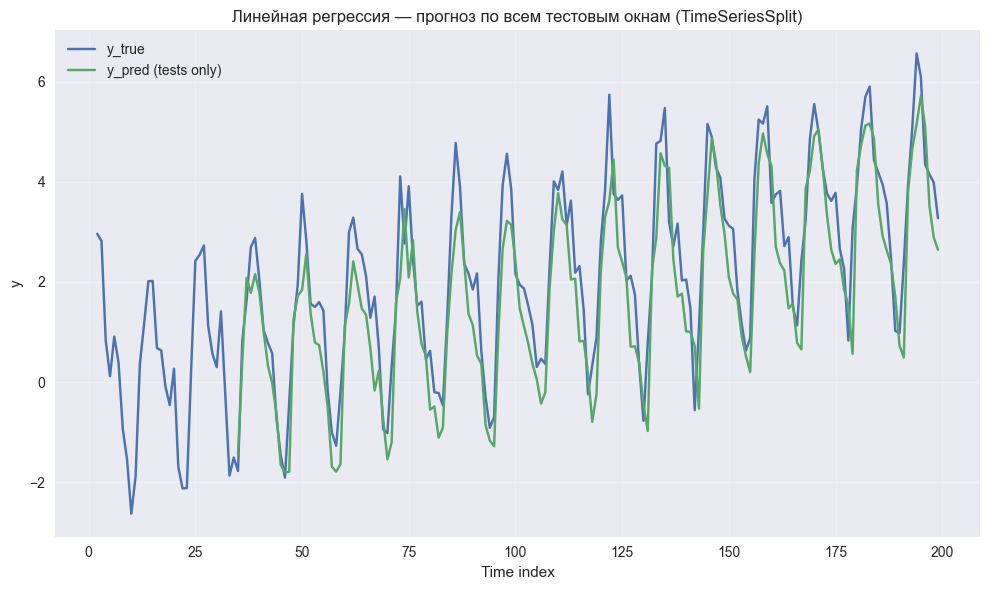

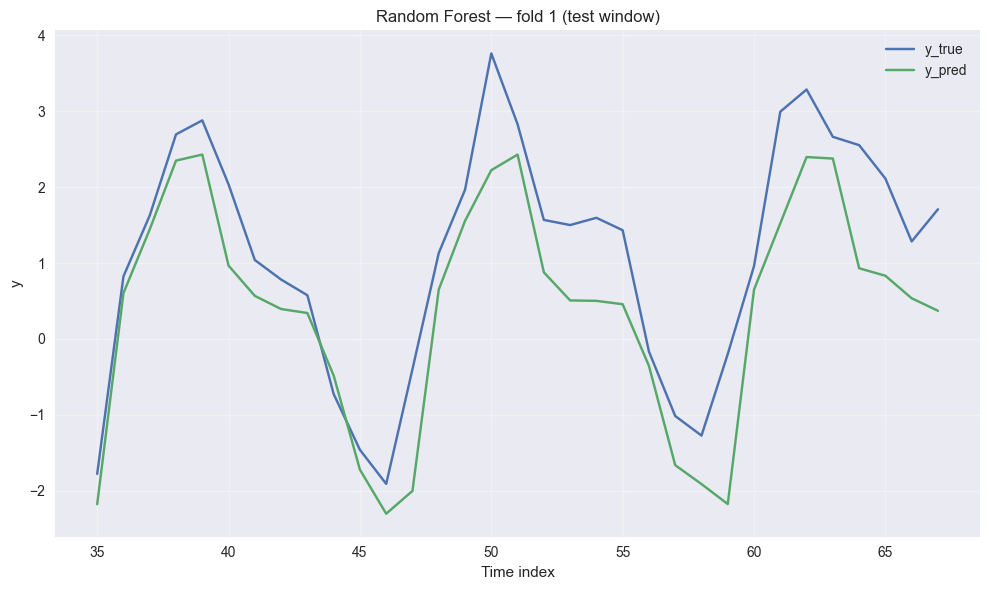

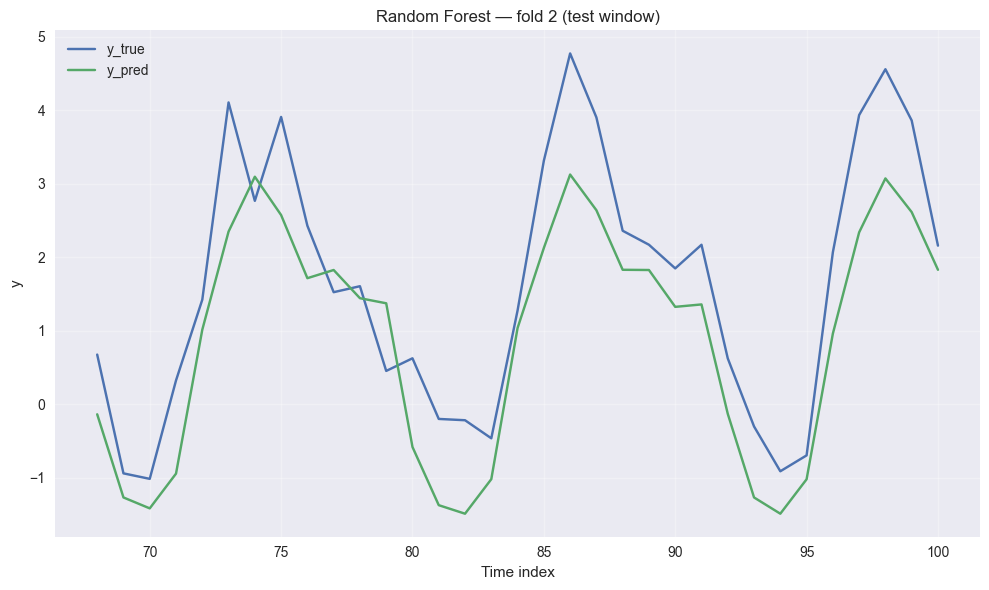

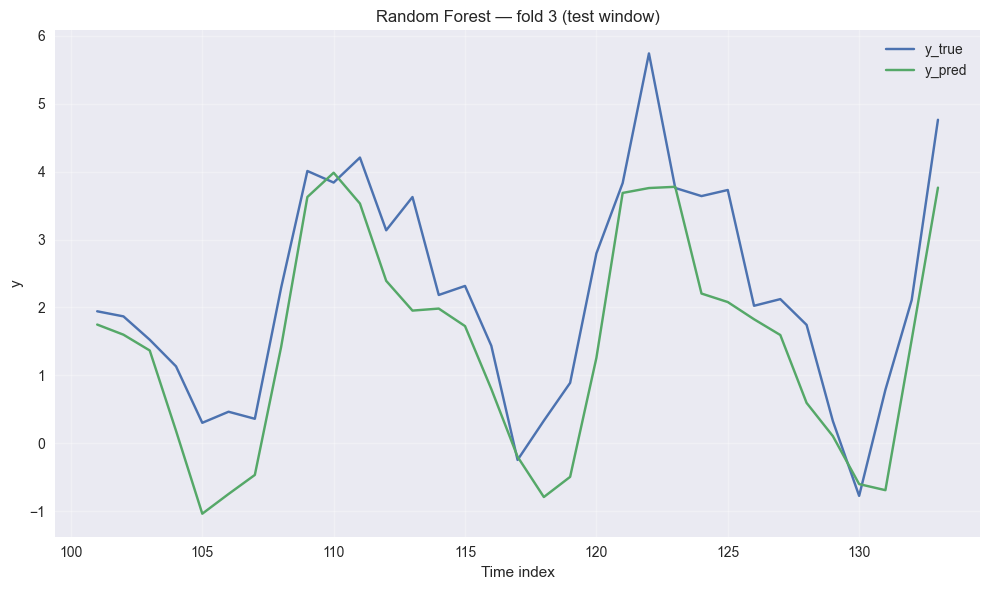

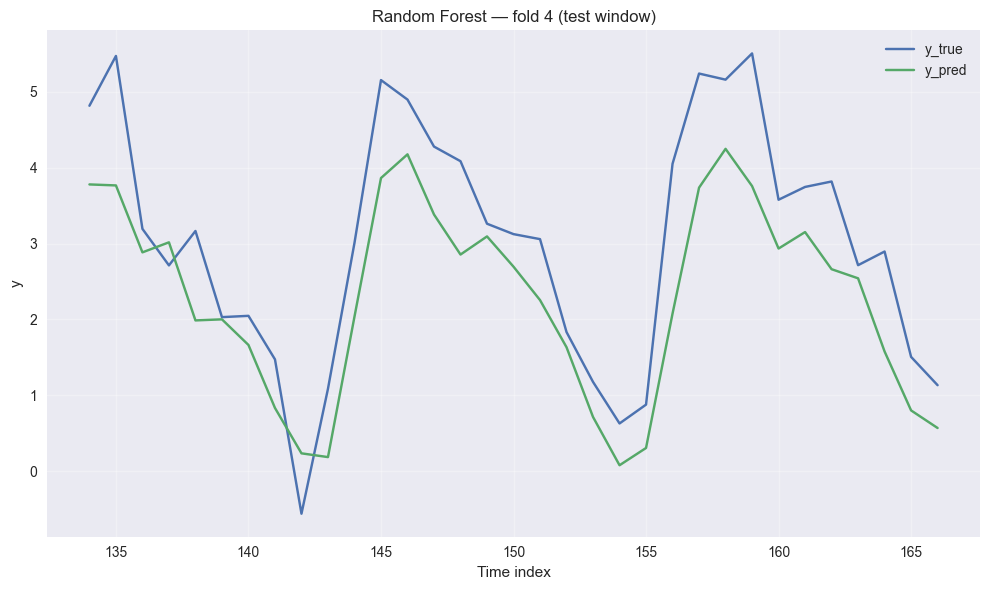

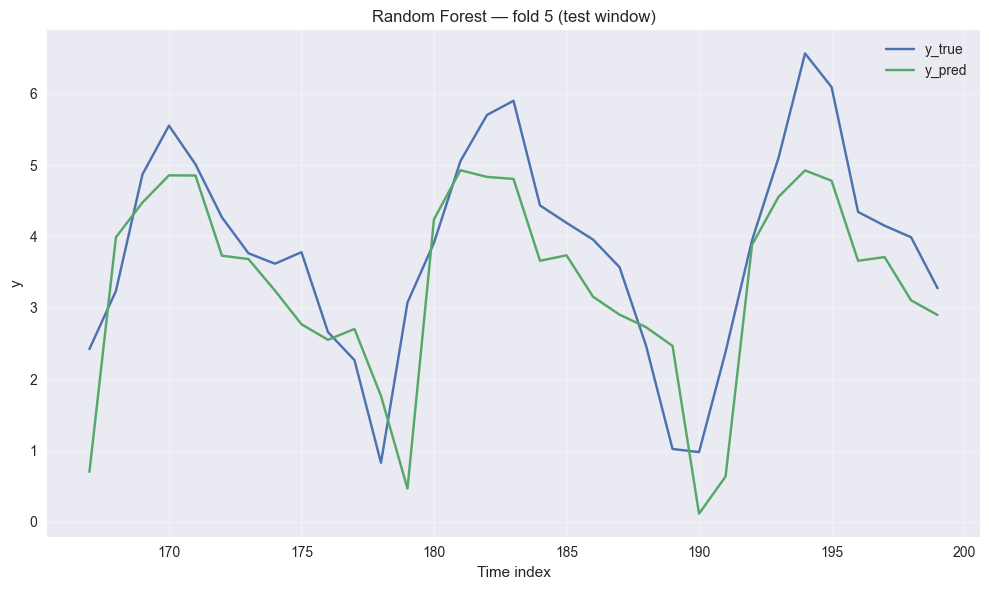

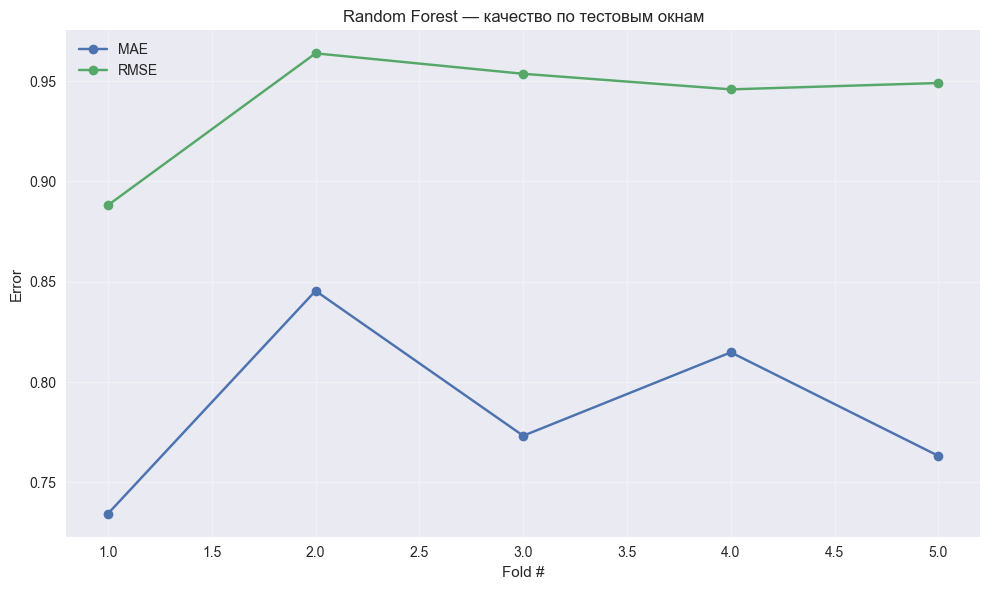

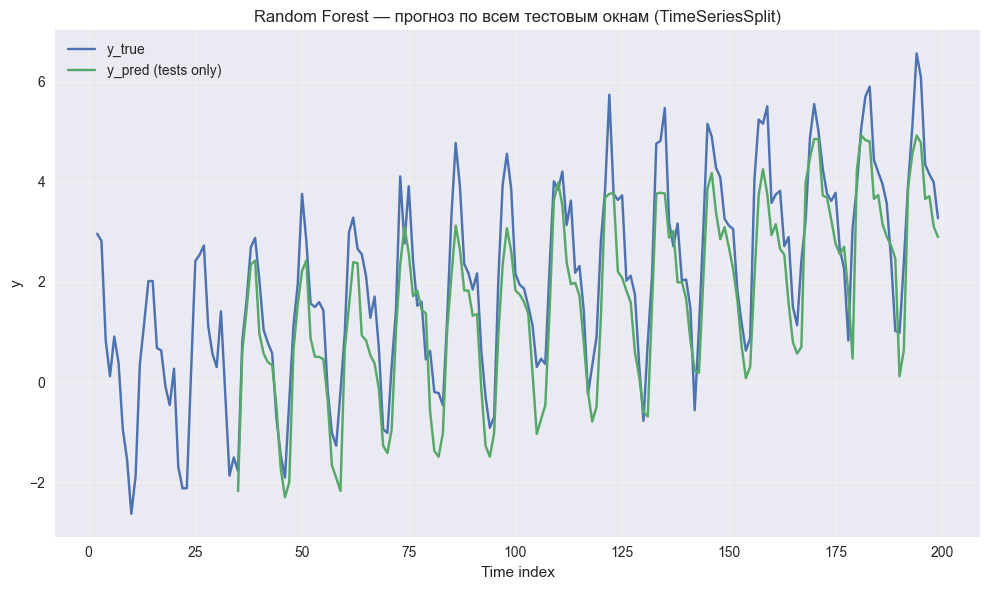

Сравнение MAE (меньше = лучше):
TimeSeriesSplit: mean=0.7342, std=0.0426
KFold(shuffle):  mean=0.6438, std=0.0606

Почему KFold(shuffle) завышает качество:
- Он перемешивает наблюдения.
- В train попадают точки из 'будущего' относительно test (нарушение причинности).
- Модель учится на паттернах/уровнях ряда, которые в реальном прогнозировании ещё неизвестны.

Пример leakage на KFold фолде:
- min(test time)  = 11
- max(train time) = 199
✅ Leak есть: в train есть точки с временем позже, чем начало test (обучение на будущем).


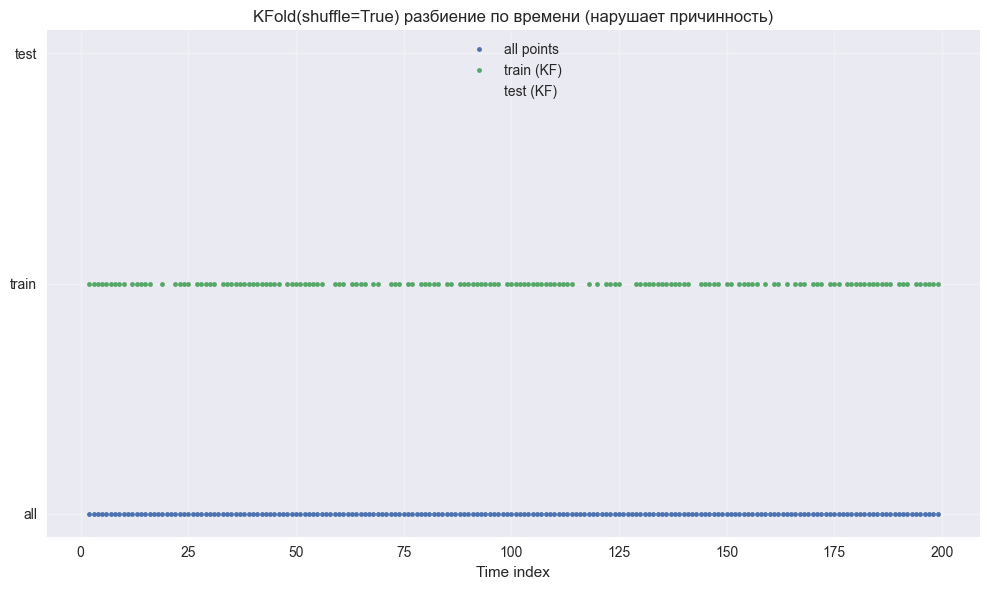

In [15]:
# Создание синтетических временных данных
def create_time_series_data(n_samples=200):
    """
    Создание синтетических временных данных с трендом, сезонностью и шумом
    """
    np.random.seed(42)
    time = np.arange(n_samples)
    
    # Тренд
    trend = 0.02 * time
    
    # Сезонность
    seasonal = 2 * np.sin(2 * np.pi * time / 12) + np.sin(2 * np.pi * time / 6)
    
    # Шум
    noise = np.random.normal(0, 0.5, n_samples)
    
    # Итоговый ряд
    y_ts = trend + seasonal + noise
    
    # Признаки: лаги, скользящие средние, временные признаки
    X_ts = np.column_stack([
        np.roll(y_ts, 1),  # lag-1
        np.roll(y_ts, 2),  # lag-2
        time % 12,         # месяц года
        np.sin(2 * np.pi * time / 12),  # сезонная компонента
        np.cos(2 * np.pi * time / 12),  # сезонная компонента
    ])
    
    # Удаление первых 2 наблюдений из-за лагов
    X_ts = X_ts[2:]
    y_ts = y_ts[2:]
    time = time[2:]
    
    return X_ts, y_ts, time

X_ts, y_ts, time_index = create_time_series_data()

def time_series_validation(X, y, time_index, models_dict, n_splits=5):
    """
    TODO: Реализуйте валидацию для временных рядов
    
    Требования:
    1. Используйте TimeSeriesSplit для корректного разделения
    2. Сравните с обычной кросс-валидацией (покажите проблемы)
    3. Визуализируйте разделение данных по времени
    4. Постройте прогнозы на каждом тестовом периоде
    5. Оцените качество прогнозирования во времени
    6. Проанализируйте стабильность моделей
    
    Параметры:
    X : array-like - признаки
    y : array-like - целевая переменная
    time_index : array-like - временные индексы
    models_dict : dict - словарь моделей
    n_splits : int - количество разделений
    
    Возвращает:
    dict с результатами валидации
    """
    validation_results = {}
    
    # Ваш код здесь
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # ===== 1) Визуализация разбиения TimeSeriesSplit =====
    plt.figure()
    for split_id, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
        plt.plot(time_index[train_idx], np.full_like(train_idx, split_id), marker='.', linestyle='None')
        plt.plot(time_index[test_idx],  np.full_like(test_idx,  split_id), marker='x', linestyle='None')
    plt.title("TimeSeriesSplit: train='.' test='x'")
    plt.xlabel("Time index")
    plt.ylabel("Split #")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ===== 2) Для каждой модели: прогнозы по фолдам + метрики во времени =====
    for name, model in models_dict.items():
        fold_metrics = []
        fold_predictions = []

        # Для графиков (соберём прогноз по всем тестовым окнам)
        y_pred_full = np.full_like(y, fill_value=np.nan, dtype=float)

        for fold_id, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test,  y_test  = X[test_idx],  y[test_idx]

            m = clone(model)
            m.fit(X_train, y_train)
            y_pred = m.predict(X_test)

            y_pred_full[test_idx] = y_pred

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            fold_metrics.append({
                "fold": fold_id,
                "train_end_time": int(time_index[train_idx][-1]),
                "test_start_time": int(time_index[test_idx][0]),
                "test_end_time": int(time_index[test_idx][-1]),
                "mae": float(mae),
                "rmse": float(rmse),
            })

            fold_predictions.append({
                "fold": fold_id,
                "test_time": time_index[test_idx],
                "y_true": y_test,
                "y_pred": y_pred
            })

            # ===== 3) Прогноз на каждом тестовом периоде =====
            plt.figure()
            plt.plot(time_index[test_idx], y_test, label="y_true")
            plt.plot(time_index[test_idx], y_pred, label="y_pred")
            plt.title(f"{name} — fold {fold_id} (test window)")
            plt.xlabel("Time index")
            plt.ylabel("y")
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # ===== 4) Метрики во времени (стабильность) =====
        maes = np.array([fm["mae"] for fm in fold_metrics])
        rmses = np.array([fm["rmse"] for fm in fold_metrics])

        plt.figure()
        plt.plot(range(1, n_splits + 1), maes, marker="o", label="MAE")
        plt.plot(range(1, n_splits + 1), rmses, marker="o", label="RMSE")
        plt.title(f"{name} — качество по тестовым окнам")
        plt.xlabel("Fold #")
        plt.ylabel("Error")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # ===== 5) Общий график ряд + прогнозы на тестовых окнах =====
        plt.figure()
        plt.plot(time_index, y, label="y_true")
        plt.plot(time_index, y_pred_full, label="y_pred (tests only)")
        plt.title(f"{name} — прогноз по всем тестовым окнам (TimeSeriesSplit)")
        plt.xlabel("Time index")
        plt.ylabel("y")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        validation_results[name] = {
            "fold_metrics": fold_metrics,
            "mae_mean": float(maes.mean()),
            "mae_std": float(maes.std()),
            "rmse_mean": float(rmses.mean()),
            "rmse_std": float(rmses.std()),
            "predictions_by_fold": fold_predictions,
            "y_pred_full_tests": y_pred_full
        }

    # ===== 6) Сравнение с "обычной" CV (покажем проблему) =====
    # Для временных рядов KFold(shuffle=True) ломает причинность.
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    cv_comparison = {}
    for name, model in models_dict.items():
        # в cross_val_score удобнее взять отрицательный MAE
        ts_scores = []
        for train_idx, test_idx in TimeSeriesSplit(n_splits=n_splits).split(X):
            m = clone(model)
            m.fit(X[train_idx], y[train_idx])
            pred = m.predict(X[test_idx])
            ts_scores.append(mean_absolute_error(y[test_idx], pred))
        ts_scores = np.array(ts_scores)

        kf_scores = []
        for train_idx, test_idx in kf.split(X):
            m = clone(model)
            m.fit(X[train_idx], y[train_idx])
            pred = m.predict(X[test_idx])
            kf_scores.append(mean_absolute_error(y[test_idx], pred))
        kf_scores = np.array(kf_scores)

        cv_comparison[name] = {
            "TimeSeriesSplit_MAE_mean": float(ts_scores.mean()),
            "TimeSeriesSplit_MAE_std": float(ts_scores.std()),
            "KFold_shuffle_MAE_mean": float(kf_scores.mean()),
            "KFold_shuffle_MAE_std": float(kf_scores.std()),
            "note": "Если KFold(shuffle=True) даёт заметно ниже MAE — это подозрительно (leakage из будущего)."
        }

    validation_results["cv_comparison"] = cv_comparison
    return validation_results

# Модели для временных рядов
ts_models = {
    'Линейная регрессия': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42),
}

# Валидация временных рядов
ts_validation_results = time_series_validation(X_ts, y_ts, time_index, ts_models)

# TODO: Добавьте анализ прогнозирования "из будущего"
def demonstrate_data_leakage_problem(X, y, time_index):
    """
    TODO: Покажите проблему data leakage при неправильной валидации временных рядов
    1. Сравните результаты TimeSeriesSplit и обычной кросс-валидации
    2. Объясните, почему обычная CV дает завышенные оценки
    3. Продемонстрируйте на конкретном примере
    """
    # Ваш код здесь
    model = LinearRegression()

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 1) Сравним MAE
    ts_mae = []
    for train_idx, test_idx in tscv.split(X):
        m = clone(model)
        m.fit(X[train_idx], y[train_idx])
        pred = m.predict(X[test_idx])
        ts_mae.append(mean_absolute_error(y[test_idx], pred))
    ts_mae = np.array(ts_mae)

    kf_mae = []
    for train_idx, test_idx in kf.split(X):
        m = clone(model)
        m.fit(X[train_idx], y[train_idx])
        pred = m.predict(X[test_idx])
        kf_mae.append(mean_absolute_error(y[test_idx], pred))
    kf_mae = np.array(kf_mae)

    print("Сравнение MAE (меньше = лучше):")
    print(f"TimeSeriesSplit: mean={ts_mae.mean():.4f}, std={ts_mae.std():.4f}")
    print(f"KFold(shuffle):  mean={kf_mae.mean():.4f}, std={kf_mae.std():.4f}")
    print("\nПочему KFold(shuffle) завышает качество:")
    print("- Он перемешивает наблюдения.")
    print("- В train попадают точки из 'будущего' относительно test (нарушение причинности).")
    print("- Модель учится на паттернах/уровнях ряда, которые в реальном прогнозировании ещё неизвестны.")

    # 2) Конкретная демонстрация на одном фолде: покажем, что train содержит будущее
    train_idx, test_idx = next(kf.split(X))
    max_train_time = time_index[train_idx].max()
    min_test_time  = time_index[test_idx].min()

    print("\nПример leakage на KFold фолде:")
    print(f"- min(test time)  = {int(min_test_time)}")
    print(f"- max(train time) = {int(max_train_time)}")
    if max_train_time > min_test_time:
        print("✅ Leak есть: в train есть точки с временем позже, чем начало test (обучение на будущем).")
    else:
        print("ℹ️ На этом конкретном фолде не видно, но при shuffle=True обычно leakage появляется часто.")

    # 3) Визуализация: один KFold фолд по времени
    plt.figure()
    plt.plot(time_index, np.zeros_like(time_index), marker=".", linestyle="None", label="all points")
    plt.plot(time_index[train_idx], np.ones_like(train_idx), marker=".", linestyle="None", label="train (KF)")
    plt.plot(time_index[test_idx],  np.ones_like(test_idx)*2, marker="x", linestyle="None", label="test (KF)")
    plt.yticks([0, 1, 2], ["all", "train", "test"])
    plt.title("KFold(shuffle=True) разбиение по времени (нарушает причинность)")
    plt.xlabel("Time index")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

demonstrate_data_leakage_problem(X_ts, y_ts, time_index)

## TODO 8: Создание комплексной системы валидации

**Задание:** Объедините все изученные методы в единую систему автоматической валидации моделей.

Запуск комплексной системы валидации...


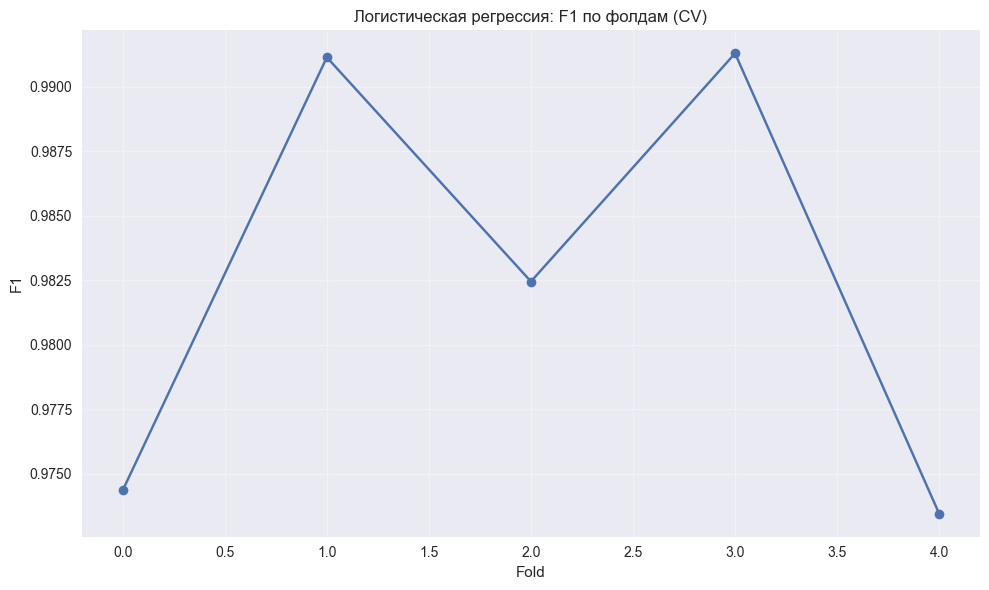

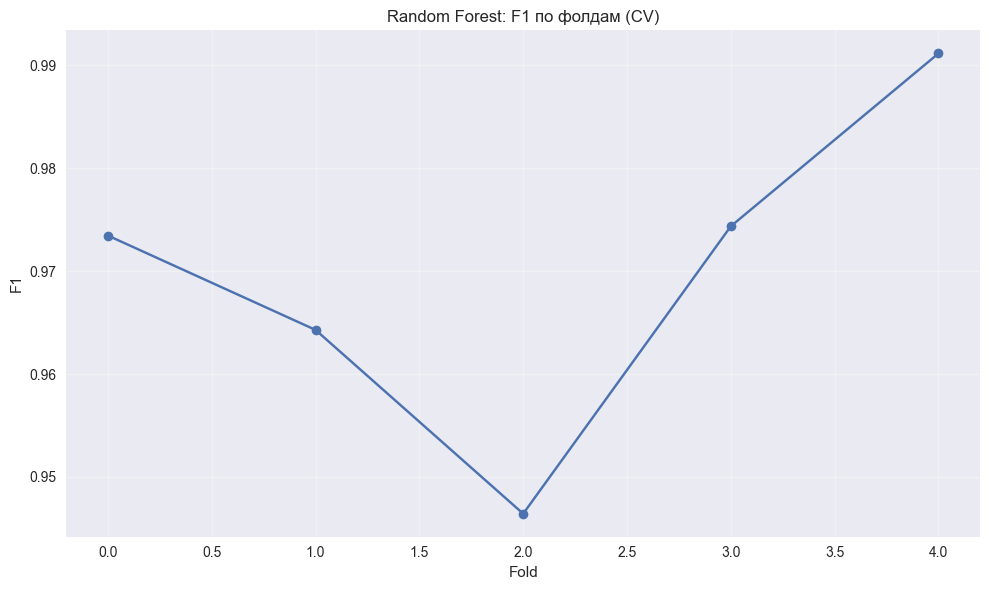

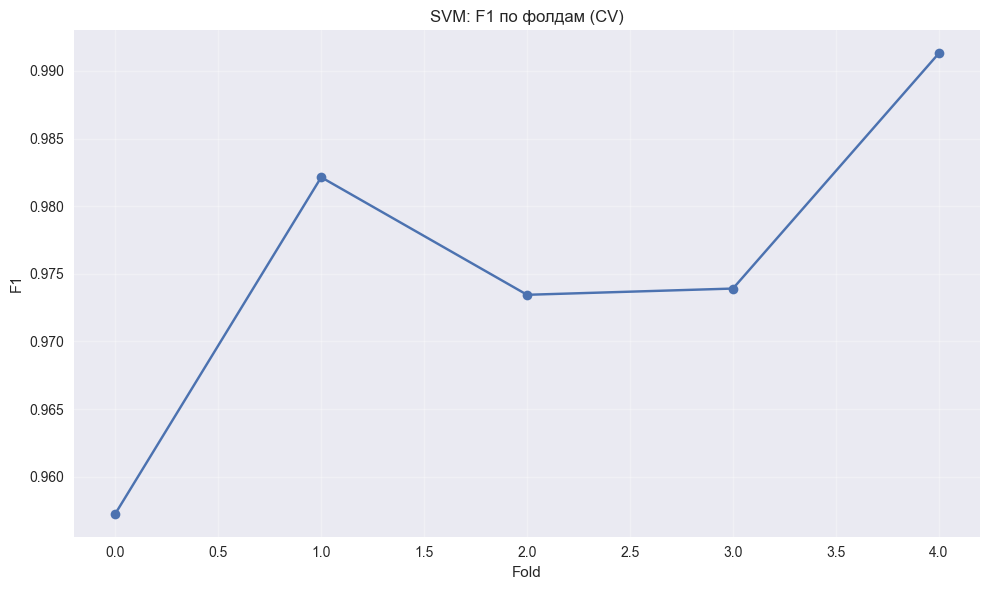


Сводная таблица результатов:


,Model,CV F1 (mean±std),CV ROC_AUC (mean±std),Holdout F1,Holdout ROC_AUC,Stability (std F1)
0,Логистическая регрессия,0.983 ± 0.008,0.996 ± 0.005,0.986,0.995,0.008
1,Random Forest,0.970 ± 0.015,0.990 ± 0.008,0.966,0.994,0.015
2,SVM,0.976 ± 0.011,0.996 ± 0.005,0.986,0.995,0.011



Статистическое сравнение моделей (парные t-тесты по фолдам):


,Model A,Model B,Metric,Mean A,Mean B,t-stat,p-value
0,Логистическая регрессия,Random Forest,F1,0.982544,0.969935,1.319648,0.257414
1,Логистическая регрессия,SVM,F1,0.982544,0.975615,1.071992,0.344094
2,Random Forest,SVM,F1,0.969935,0.975615,-0.749096,0.495447



ИТОГОВЫЙ ОТЧЕТ ВАЛИДАЦИИ
Тип задачи: classification
Стратегия CV: StratifiedKFold

Лучшая модель: Логистическая регрессия — Максимальный mean F1 по CV.

Сводка результатов (CV + holdout):
                  Model CV F1 (mean±std) CV ROC_AUC (mean±std) Holdout F1 Holdout ROC_AUC Stability (std F1)
Логистическая регрессия    0.983 ± 0.008         0.996 ± 0.005      0.986           0.995              0.008
          Random Forest    0.970 ± 0.015         0.990 ± 0.008      0.966           0.994              0.015
                    SVM    0.976 ± 0.011         0.996 ± 0.005      0.986           0.995              0.011

Статистическое сравнение (топ по p-value):
                Model A       Model B Metric   Mean A   Mean B    t-stat  p-value
Логистическая регрессия Random Forest     F1 0.982544 0.969935  1.319648 0.257414
Логистическая регрессия           SVM     F1 0.982544 0.975615  1.071992 0.344094
          Random Forest           SVM     F1 0.969935 0.975615 -0.749096 0.495447

Ре

In [21]:
class ModelValidationSystem:
    """
    TODO: Создайте класс для комплексной валидации моделей
    
    Требования:
    1. Автоматическое определение типа задачи (классификация/регрессия)
    2. Выбор подходящих метрик в зависимости от задачи
    3. Автоматический выбор стратегии кросс-валидации
    4. Обнаружение и предупреждение о data leakage
    5. Статистическое сравнение моделей
    6. Генерация отчета с рекомендациями
    7. Визуализация всех важных аспектов
    """
    
    def __init__(self, task_type='auto', cv_strategy='auto', random_state=42):
        """
        TODO: Инициализация системы валидации
        
        Параметры:
        task_type : str - 'classification', 'regression', или 'auto'
        cv_strategy : str - стратегия кросс-валидации или 'auto'
        random_state : int - семя случайности
        """
        # Ваш код здесь
        self.task_type = task_type
        self.cv_strategy = cv_strategy
        self.random_state = random_state

    
    def detect_task_type(self, y):
        """
        TODO: Автоматическое определение типа задачи
        """
        # Ваш код здесь
        if self.task_type in ["classification", "regression"]:
            return self.task_type

        y_arr = np.asarray(y)
        # эвристика: мало уникальных значений => классификация
        unique_vals = np.unique(y_arr)
        n_unique = len(unique_vals)

        # Если int/bool и уникальных мало -> классификация
        if np.issubdtype(y_arr.dtype, np.integer) or np.issubdtype(y_arr.dtype, np.bool_):
            if n_unique <= 20:
                return "classification"
            # много уникальных ints может быть регрессией, но чаще это кодировки классов — оставим как классификацию
            return "classification"

        # float: обычно регрессия, но бывает 0/1
        if n_unique <= 20 and set(unique_vals).issubset({0, 1}):
            return "classification"

        return "regression"
    
    def select_cv_strategy(self, X, y, time_index=None, cv_folds=5):
        """
        TODO: Выбор оптимальной стратегии кросс-валидации
        """
        # Ваш код здесь
        # если явно задано
        if self.cv_strategy != "auto":
            if self.cv_strategy == "timeseries":
                return TimeSeriesSplit(n_splits=cv_folds)
            if self.cv_strategy == "stratified":
                return StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
            if self.cv_strategy == "kfold":
                return KFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
            # fallback
            return KFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)

        # auto
        if time_index is not None:
            return TimeSeriesSplit(n_splits=cv_folds)

        task = self.detect_task_type(y)
        if task == "classification":
            return StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        else:
            return KFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
    
    def detect_data_leakage(self, X, y,  time_index=None):
        """
        TODO: Обнаружение потенциальных проблем с утечкой данных
        """
        # Ваш код здесь
        warnings = []

        X_arr = np.asarray(X)
        y_arr = np.asarray(y)

        # 3.1) Если time_index есть, проверим монотонность
        if time_index is not None:
            t = np.asarray(time_index)
            if not np.all(np.diff(t) >= 0):
                warnings.append("time_index не отсортирован по времени — это ломает TimeSeriesSplit и может давать leakage.")

        # 3.2) Если есть признаки, подозрительно похожие на y (высокая корреляция) — сигнал утечки
        # Работает только для регрессии или бинарной классификации (грубая оценка)
        try:
            task = self.detect_task_type(y_arr)
            if task == "regression":
                # корреляция каждого признака с y
                corrs = []
                for j in range(X_arr.shape[1]):
                    xj = X_arr[:, j]
                    if np.std(xj) < 1e-12:
                        corrs.append(0.0)
                        continue
                    corrs.append(np.corrcoef(xj, y_arr)[0, 1])
                max_abs_corr = float(np.nanmax(np.abs(corrs)))
                if max_abs_corr > 0.98:
                    warnings.append(
                        f"Есть признак с очень высокой корреляцией с y (|corr|≈{max_abs_corr:.3f}). "
                        "Возможна утечка (например, target leakage / использование будущей информации)."
                    )
            else:
                # бинарная классификация: сравним средние по классам, если разница слишком экстремальная
                uniq = np.unique(y_arr)
                if len(uniq) == 2:
                    c0, c1 = uniq[0], uniq[1]
                    X0 = X_arr[y_arr == c0]
                    X1 = X_arr[y_arr == c1]
                    if X0.size > 0 and X1.size > 0:
                        # normalized mean diff
                        diffs = np.abs(X1.mean(axis=0) - X0.mean(axis=0)) / (X_arr.std(axis=0) + 1e-9)
                        max_diff = float(np.max(diffs))
                        if max_diff > 8:
                            warnings.append(
                                f"Есть признак с экстремальным разделением классов (z-diff≈{max_diff:.2f}). "
                                "Это может быть нормой, но часто так выглядит утечка (признак напрямую кодирует цель)."
                            )
        except Exception:
            pass

        # 3.3) Проверка лаговых признаков (если они строились через roll):
        # если в X есть первые элементы равные хвосту ряда — признак неправильной подготовки
        # (не всегда, но полезный сигнал)
        # Это можно проверить только если X выглядит как лаги y, поэтому делаем мягкое предупреждение
        if X_arr.ndim == 2 and X_arr.shape[0] > 10:
            # если встречаются повторяющиеся блоки в начале/конце — подозрительно
            if np.allclose(X_arr[0], X_arr[-1], atol=1e-8):
                warnings.append(
                    "Первые и последние строки X очень похожи. Если лаги создавались через np.roll, "
                    "убедись, что ты удалил первые наблюдения (иначе в начале будут значения из будущего)."
                )

        return warnings

    def _get_scoring(self, task):
        if task == "classification":
            # в cross_validate удобно использовать готовые scorer-строки
            # roc_auc требует predict_proba/decision_function — не у всех моделей; добавим осторожно
            return {
                "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
                "f1": "f1",
                "roc_auc": "roc_auc"
            }
        else:
            return {
                "neg_mse": "neg_mean_squared_error",
                "neg_mae": "neg_mean_absolute_error",
                "r2": "r2"
            }

    # =========================
    # 5) Основная валидация
    # =========================
    def validate_models(self, X, y, models_dict, cv_folds=5, test_size=0.2, time_index=None):
        results = {}
        task = self.detect_task_type(y)
        results["task_type"] = task

        # Leakage warnings
        leakage_warnings = self.detect_data_leakage(X, y, time_index=time_index)
        results["leakage_warnings"] = leakage_warnings

        # CV strategy
        cv_splitter = self.select_cv_strategy(X, y, cv_folds=cv_folds, time_index=time_index)
        results["cv_strategy"] = type(cv_splitter).__name__

        # Train/Test split (для TimeSeriesSplit — берём последний кусок как test)
        X_arr = np.asarray(X)
        y_arr = np.asarray(y)

        if isinstance(cv_splitter, TimeSeriesSplit):
            # holdout test = last test_size fraction
            n = len(y_arr)
            split_point = int(np.floor(n * (1 - test_size)))
            X_train, X_test = X_arr[:split_point], X_arr[split_point:]
            y_train, y_test = y_arr[:split_point], y_arr[split_point:]
            t_train = time_index[:split_point] if time_index is not None else None
            t_test  = time_index[split_point:] if time_index is not None else None
        else:
            strat = y_arr if task == "classification" else None
            X_train, X_test, y_train, y_test = train_test_split(
                X_arr, y_arr,
                test_size=test_size,
                stratify=strat,
                random_state=self.random_state
            )
            t_train = t_test = None

        results["holdout_split"] = {
            "X_train_shape": X_train.shape,
            "X_test_shape": X_test.shape
        }

        scoring = self._get_scoring(task)

        # ===== Валидация каждой модели =====
        per_model = {}
        for name, model in models_dict.items():
            # CV metrics
            cv_out = cross_validate(
                model, X_train, y_train,
                cv=cv_splitter,
                scoring=scoring,
                n_jobs=-1,
                return_train_score=True,
                error_score="raise"
            )

            # Приводим ошибки в позитивные значения
            model_res = {"cv_raw": cv_out}

            if task == "regression":
                mse_scores = -cv_out["test_neg_mse"]
                mae_scores = -cv_out["test_neg_mae"]
                r2_scores  = cv_out["test_r2"]

                model_res["cv_scores"] = {
                    "mse": mse_scores,
                    "mae": mae_scores,
                    "r2":  r2_scores
                }
                model_res["cv_summary"] = {
                    "mse_mean": float(mse_scores.mean()), "mse_std": float(mse_scores.std()),
                    "mae_mean": float(mae_scores.mean()), "mae_std": float(mae_scores.std()),
                    "r2_mean":  float(r2_scores.mean()),  "r2_std":  float(r2_scores.std()),
                }

            else:
                # roc_auc может не посчитаться на некоторых моделях — в таком случае sklearn упадёт
                # но у тебя SVC(probability=True) и LR и RF — всё ок.
                model_res["cv_scores"] = {
                    "accuracy": cv_out["test_accuracy"],
                    "precision": cv_out["test_precision"],
                    "recall": cv_out["test_recall"],
                    "f1": cv_out["test_f1"],
                    "roc_auc": cv_out["test_roc_auc"]
                }
                model_res["cv_summary"] = {
                    "accuracy_mean": float(cv_out["test_accuracy"].mean()), "accuracy_std": float(cv_out["test_accuracy"].std()),
                    "precision_mean": float(cv_out["test_precision"].mean()), "precision_std": float(cv_out["test_precision"].std()),
                    "recall_mean": float(cv_out["test_recall"].mean()), "recall_std": float(cv_out["test_recall"].std()),
                    "f1_mean": float(cv_out["test_f1"].mean()), "f1_std": float(cv_out["test_f1"].std()),
                    "roc_auc_mean": float(cv_out["test_roc_auc"].mean()), "roc_auc_std": float(cv_out["test_roc_auc"].std()),
                }

            # Holdout test evaluation
            m = clone(model)
            m.fit(X_train, y_train)
            y_pred = m.predict(X_test)

            if task == "regression":
                test_mse = mean_squared_error(y_test, y_pred)
                test_mae = mean_absolute_error(y_test, y_pred)
                test_r2  = r2_score(y_test, y_pred)
                model_res["test_metrics"] = {"mse": float(test_mse), "mae": float(test_mae), "r2": float(test_r2)}

                # Plots
                plt.figure()
                plt.scatter(y_test, y_pred, alpha=0.7)
                min_y, max_y = float(np.min(y_test)), float(np.max(y_test))
                plt.plot([min_y, max_y], [min_y, max_y], linestyle="--")
                plt.title(f"{name}: y_pred vs y_true (holdout)")
                plt.xlabel("y_true")
                plt.ylabel("y_pred")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

                residuals = y_test - y_pred
                plt.figure()
                plt.scatter(y_pred, residuals, alpha=0.7)
                plt.axhline(0, linestyle="--")
                plt.title(f"{name}: Residuals vs y_pred (holdout)")
                plt.xlabel("y_pred")
                plt.ylabel("residuals")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

            else:
                test_acc = accuracy_score(y_test, y_pred)
                test_prec = precision_score(y_test, y_pred)
                test_rec = recall_score(y_test, y_pred)
                test_f1 = f1_score(y_test, y_pred)

                # AUC на holdout — если есть proba/decision_function
                test_auc = None
                if hasattr(m, "predict_proba"):
                    proba = m.predict_proba(X_test)[:, 1]
                    test_auc = roc_auc_score(y_test, proba)
                elif hasattr(m, "decision_function"):
                    scores = m.decision_function(X_test)
                    test_auc = roc_auc_score(y_test, scores)

                model_res["test_metrics"] = {
                    "accuracy": float(test_acc),
                    "precision": float(test_prec),
                    "recall": float(test_rec),
                    "f1": float(test_f1),
                    "roc_auc": (float(test_auc) if test_auc is not None else None)
                }

                # Quick plot: distribution of CV scores (F1)
                plt.figure()
                plt.plot(model_res["cv_scores"]["f1"], marker="o")
                plt.title(f"{name}: F1 по фолдам (CV)")
                plt.xlabel("Fold")
                plt.ylabel("F1")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

            # stability: std of primary metric
            if task == "classification":
                stability = float(model_res["cv_scores"]["f1"].std())
                primary_mean = float(model_res["cv_summary"]["f1_mean"])
                primary_name = "f1"
            else:
                stability = float(model_res["cv_scores"]["mae"].std())
                primary_mean = float(model_res["cv_summary"]["mae_mean"])
                primary_name = "mae"

            model_res["stability_std_primary_metric"] = stability
            model_res["primary_metric_name"] = primary_name
            model_res["primary_metric_mean_cv"] = primary_mean

            per_model[name] = model_res

        results["models"] = per_model

        # ===== 5) Статистическое сравнение моделей (парный t-тест по фолдам) =====
        model_names = list(models_dict.keys())
        stats_rows = []

        if len(model_names) >= 2:
            for i in range(len(model_names)):
                for j in range(i + 1, len(model_names)):
                    a, b = model_names[i], model_names[j]

                    if task == "classification":
                        a_scores = results["models"][a]["cv_scores"]["f1"]
                        b_scores = results["models"][b]["cv_scores"]["f1"]
                        metric_used = "F1"
                    else:
                        # MAE меньше лучше, но ttest_rel сравнивает средние — норм, просто интерпретируй знак
                        a_scores = results["models"][a]["cv_scores"]["mae"]
                        b_scores = results["models"][b]["cv_scores"]["mae"]
                        metric_used = "MAE"

                    t_stat, p_val = ttest_rel(a_scores, b_scores)
                    stats_rows.append({
                        "Model A": a, "Model B": b,
                        "Metric": metric_used,
                        "Mean A": float(np.mean(a_scores)),
                        "Mean B": float(np.mean(b_scores)),
                        "t-stat": float(t_stat),
                        "p-value": float(p_val)
                    })

        results["stat_tests"] = pd.DataFrame(stats_rows).sort_values("p-value") if stats_rows else pd.DataFrame()

        # ===== 6) Выбор лучшей модели =====
        if task == "classification":
            best_model = max(model_names, key=lambda n: results["models"][n]["cv_summary"]["f1_mean"])
            best_reason = "Максимальный mean F1 по CV."
        else:
            best_model = min(model_names, key=lambda n: results["models"][n]["cv_summary"]["mae_mean"])
            best_reason = "Минимальный mean MAE по CV (меньше = лучше)."

        results["best_model"] = {"name": best_model, "reason": best_reason}

        # ===== Сводная таблица =====
        summary = []
        for n in model_names:
            if task == "classification":
                s = results["models"][n]["cv_summary"]
                t = results["models"][n]["test_metrics"]
                summary.append({
                    "Model": n,
                    "CV F1 (mean±std)": f"{s['f1_mean']:.3f} ± {s['f1_std']:.3f}",
                    "CV ROC_AUC (mean±std)": f"{s['roc_auc_mean']:.3f} ± {s['roc_auc_std']:.3f}",
                    "Holdout F1": f"{t['f1']:.3f}",
                    "Holdout ROC_AUC": ("-" if t["roc_auc"] is None else f"{t['roc_auc']:.3f}"),
                    "Stability (std F1)": f"{results['models'][n]['stability_std_primary_metric']:.3f}"
                })
            else:
                s = results["models"][n]["cv_summary"]
                t = results["models"][n]["test_metrics"]
                summary.append({
                    "Model": n,
                    "CV MAE (mean±std)": f"{s['mae_mean']:.3f} ± {s['mae_std']:.3f}",
                    "CV R2 (mean±std)": f"{s['r2_mean']:.3f} ± {s['r2_std']:.3f}",
                    "Holdout MAE": f"{t['mae']:.3f}",
                    "Holdout R2": f"{t['r2']:.3f}",
                    "Stability (std MAE)": f"{results['models'][n]['stability_std_primary_metric']:.3f}"
                })

        results["summary_table"] = pd.DataFrame(summary)

        print("\nСводная таблица результатов:")
        display(results["summary_table"])

        if not results["stat_tests"].empty:
            print("\nСтатистическое сравнение моделей (парные t-тесты по фолдам):")
            display(results["stat_tests"])

        if leakage_warnings:
            print("\n⚠️ Предупреждения о возможной утечке данных:")
            for w in leakage_warnings:
                print("-", w)

        return results

    # =========================
    # 6) Генерация отчёта
    # =========================
    def generate_report(self, validation_results):
        task = validation_results.get("task_type", "unknown")
        best = validation_results.get("best_model", {})
        summary_df = validation_results.get("summary_table", None)
        stat_df = validation_results.get("stat_tests", None)
        warnings = validation_results.get("leakage_warnings", [])

        lines = []
        lines.append(f"Тип задачи: {task}")
        lines.append(f"Стратегия CV: {validation_results.get('cv_strategy')}")
        lines.append("")
        lines.append(f"Лучшая модель: {best.get('name')} — {best.get('reason')}")
        lines.append("")

        # Сводка по моделям (коротко)
        if isinstance(summary_df, pd.DataFrame) and not summary_df.empty:
            lines.append("Сводка результатов (CV + holdout):")
            lines.append(summary_df.to_string(index=False))
            lines.append("")

        # Стат сравнение
        if isinstance(stat_df, pd.DataFrame) and not stat_df.empty:
            # покажем топ-3 самых значимых сравнений
            top = stat_df.head(3)
            lines.append("Статистическое сравнение (топ по p-value):")
            lines.append(top.to_string(index=False))
            lines.append("")

        # Leakage warnings
        if warnings:
            lines.append("⚠️ Возможные проблемы/утечки данных:")
            for w in warnings:
                lines.append(f"- {w}")
            lines.append("")

        # Рекомендации
        lines.append("Рекомендации:")
        if task == "classification":
            lines.append("- Для медицинских/критичных задач ориентируйся на Recall/F1 и ROC-AUC, а не только на Accuracy.")
            lines.append("- Если важнее не пропустить положительный класс — подбирай порог вероятности под высокий Recall.")
            lines.append("- Для улучшения: GridSearch по гиперпараметрам, калибровка вероятностей, анализ ошибок (confusion matrix).")
        else:
            lines.append("- Смотри residual plots: структура/воронка = нелинейность или гетероскедастичность.")
            lines.append("- Для улучшения: feature engineering, более сложные модели (GBM), настройка гиперпараметров, robust loss.")
        lines.append("- Если разница между моделями по CV мала и p-value высокий — выбирай более простую/стабильную модель.")
        lines.append("")

        # Стабильность
        models = validation_results.get("models", {})
        if models:
            lines.append("Стабильность (std по основной метрике):")
            for name, info in models.items():
                lines.append(f"- {name}: std({info['primary_metric_name']}) = {info['stability_std_primary_metric']:.4f}")
            lines.append("")

        return "\n".join(lines)

# Тестирование системы валидации
validation_system = ModelValidationSystem()

# Модели для тестирования
test_models = {
    'Логистическая регрессия': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42, probability=True))
    ])
}

# Запуск комплексной валидации
print("Запуск комплексной системы валидации...")
comprehensive_results = validation_system.validate_models(X, y, test_models)

# Генерация отчета
final_report = validation_system.generate_report(comprehensive_results)

print("\n" + "="*80)
print("ИТОГОВЫЙ ОТЧЕТ ВАЛИДАЦИИ")
print("="*80)
print(final_report)

## Заключение

### Что вы изучили в этой практической работе:

1. **Правильное разделение данных** с сохранением пропорций классов
2. **Различные методы кросс-валидации** и их применение
3. **Комплексный анализ метрик** для классификации и регрессии
4. **Диагностику переобучения** с помощью кривых обучения
5. **Настройку гиперпараметров** с proper validation
6. **Специальные методы** для временных рядов
7. **Создание автоматизированной системы** валидации

### Ключевые принципы валидации:

- **Всегда** отделяйте тестовую выборку перед началом работы
- **Используйте** подходящую стратегию кросс-валидации для ваших данных
- **Избегайте** data leakage через proper preprocessing в pipeline
- **Выбирайте** метрики, соответствующие бизнес-задаче
- **Проводите** статистическое сравнение моделей
- **Анализируйте** не только средние значения, но и стабильность результатов

### Дальнейшие шаги:

- Применить изученные методы на собственных данных
- Изучить продвинутые техники валидации (Nested CV, Bootstrap)
- Освоить методы работы с несбалансированными данными
- Изучить Bayesian optimization для настройки гиперпараметров